Luka Dubravica, 2025

Supervised by Hardik Rajpal and Alberto Liardi

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime
from scipy.io import loadmat

In [2]:
# Read the Excel file
file_name = 'Data_4_Import_REST.xlsx'
excel_sheet_name = 'Depression Rest'
file_path = os.path.join("Depression_Study", "depression_data", file_name)
df_raw = pd.read_excel(file_path, sheet_name=excel_sheet_name)

# Load CSER values from MAT file
cser_values = loadmat("cser_values.mat")

# Extract field names from cser_open and cser_closed
field_names_open = [int(name[1:]) for name in cser_values['cser_open'].dtype.names]
field_names_closed = [int(name[1:]) for name in cser_values['cser_closed'].dtype.names]

# Extract values from the CSER data
cser_open = np.array([value[0][0] for sublist in cser_values['cser_open'][0] for value in sublist])
cser_closed = np.array([value[0][0] for sublist in cser_values['cser_closed'][0] for value in sublist])

# Extract band values into separate list for each band
cser_band_open = [np.array([value[0][i] for sublist in cser_values['cser_band_open'][0] for value in sublist]) for i in range(6)]
cser_band_closed = [np.array([value[0][i] for sublist in cser_values['cser_band_closed'][0] for value in sublist]) for i in range(6)]

# Extract CSER from the for each of the 60 sources
cser_source_open = [np.array([value[0][i] for sublist in cser_values['cser_source_open'][0] for value in sublist]) for i in range(60)]
cser_source_closed = [np.array([value[0][i] for sublist in cser_values['cser_source_closed'][0] for value in sublist]) for i in range(60)]

# Extract CSER from the for each of the 60 sources
cser_source_band_open = np.array([[np.array([value[j][i] for sublist in cser_values['cser_source_band_open'][0] for value in sublist]) for i in range(60)] for j in range(6)])
cser_source_band_closed = np.array([[np.array([value[j][i] for sublist in cser_values['cser_source_band_closed'][0] for value in sublist]) for i in range(60)] for j in range(6)])
# i source x j band

# Extract AAL source names
source_names = [(cser_values['source_names'][i][0][0]) for i in range(60)]

In [3]:
# print(df_raw.columns.tolist())
df = df_raw.copy()
df = df.drop(columns=['MDD_note', 'HamD'])
# print(df.columns.tolist())

missing_ids_open = set(df['id']) - set(field_names_open)
df = df[~df['id'].isin(missing_ids_open)]

df['eyes'] = 'open'
df['area'] = 'brain'
df['band'] = 'broadband'
df['CSER'] = np.nan

# Reorder columns: insert ['eyes', 'area', 'band', 'CSER'] after 'id'
cols = df.columns.tolist()
insert_cols = ['eyes', 'area', 'band', 'CSER']
# Remove if already present to avoid duplication
for c in insert_cols:
    if c in cols:
        cols.remove(c)
id_idx = cols.index('id')
new_cols = cols[:id_idx+1] + insert_cols + cols[id_idx+1:]
df = df[new_cols]

print(df.columns.tolist())
print()

df_copy = df.copy()

print("DF Shape:", df.shape)

# OPEN / BRAIN / BROADBAND
for i, row in df.iterrows():
    id_value = row['id']
    if id_value in field_names_open:
        df.at[i, 'CSER'] = cser_open[field_names_open.index(id_value)]

print("DF Shape after inserting [open / brain / broadband]:", df.shape)

# CLOSED / BRAIN / BROADBAND
df_closed = df_copy.copy()
df_closed['eyes'] = 'closed'
df_closed['area'] = 'brain'
df_closed['band'] = 'broadband'
# Add CSER values for closed eyes
for i, row in df_closed.iterrows():
    id_value = row['id']
    if id_value in field_names_closed:
        df_closed.at[i, 'CSER'] = cser_closed[field_names_closed.index(id_value)]
df = pd.concat([df, df_closed], ignore_index=True)

print("DF Shape after inserting [closed / brain / broadband]:", df.shape)

# open / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
# band_names = ["1-4","4-8","8-12","12-30","30-100"]
band_names = ["1-4","4-8","8-12","12-30","30-100","1-12"]
for i, band in enumerate(band_names):
    df_band = df_copy.copy()
    df_band['eyes'] = 'open'
    df_band['area'] = 'brain'
    df_band['band'] = band
    for j, row in df_band.iterrows():
        id_value = row['id']
        if id_value in field_names_open:
            data_index = field_names_open.index(id_value)
            df_band.at[j, 'CSER'] = cser_band_open[i][data_index]
    df = pd.concat([df, df_band], ignore_index=True)

print("DF Shape after inserting [open / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]:", df.shape)

# closed / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
for i, band in enumerate(band_names):
    df_band = df_copy.copy()
    df_band['eyes'] = 'closed'
    df_band['area'] = 'brain'
    df_band['band'] = band
    for j, row in df_band.iterrows():
        id_value = row['id']
        if id_value in field_names_closed:
            data_index = field_names_closed.index(id_value)
            df_band.at[j, 'CSER'] = cser_band_closed[i][data_index]
    df = pd.concat([df, df_band], ignore_index=True)

print("DF Shape after inserting [closed / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]:", df.shape)

# open / src01, src02, ..., src60 / broadband
for i in range(60):
    df_source = df_copy.copy()
    df_source['eyes'] = 'open'
    df_source['area'] = f'src{i+1:02d}_{source_names[i]}'
    df_source['band'] = 'broadband'
    for j, row in df_source.iterrows():
        id_value = row['id']
        if id_value in field_names_open:
            data_index = field_names_open.index(id_value)
            df_source.at[j, 'CSER'] = cser_source_open[i][data_index]
    df = pd.concat([df, df_source], ignore_index=True)

print("DF Shape after inserting [open / src01, src02, ..., src60 / broadband]:", df.shape)

# closed / src01, src02, ..., src60 / broadband
for i in range(60):
    df_source = df_copy.copy()
    df_source['eyes'] = 'closed'
    df_source['area'] = f'src{i+1:02d}_{source_names[i]}'
    df_source['band'] = 'broadband'
    for j, row in df_source.iterrows():
        id_value = row['id']
        if id_value in field_names_closed:
            data_index = field_names_closed.index(id_value)
            df_source.at[j, 'CSER'] = cser_source_closed[i][data_index]
    df = pd.concat([df, df_source], ignore_index=True)

print("DF Shape after inserting [closed / src01, src02, ..., src60 / broadband]:", df.shape)

# open / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
for i in range(60):
    for j, band in enumerate(band_names):
        df_source_band = df_copy.copy()
        df_source_band['eyes'] = 'open'
        df_source_band['area'] = f'src{i+1:02d}_{source_names[i]}'
        df_source_band['band'] = band
        for k, row in df_source_band.iterrows():
            id_value = row['id']
            if id_value in field_names_open:
                data_index = field_names_open.index(id_value)
                df_source_band.at[k, 'CSER'] = cser_source_band_open[j][i][data_index]
        df = pd.concat([df, df_source_band], ignore_index=True)

print("DF Shape after inserting [open / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]:", df.shape)

# closed / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
for i in range(60):
    for j, band in enumerate(band_names):
        df_source_band = df_copy.copy()
        df_source_band['eyes'] = 'closed'
        df_source_band['area'] = f'src{i+1:02d}_{source_names[i]}'
        df_source_band['band'] = band
        for k, row in df_source_band.iterrows():
            id_value = row['id']
            if id_value in field_names_closed:
                data_index = field_names_closed.index(id_value)
                df_source_band.at[k, 'CSER'] = cser_source_band_closed[j][i][data_index]
        df = pd.concat([df, df_source_band], ignore_index=True)

print("DF Shape after inserting [closed / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]:", df.shape)

# open, closed / frontal, occipital, parietal, sensorimotor, temporal / broadband, 1-4, 4-8, 8-12, 12-30, 30-100, 1-12
region_map = {
    'frontal': [f'src{i+1:02d}_{source_names[i]}' for i in range(2, 16)] + [f'src{i:02d}_{source_names[i]}' for i in range(18, 24)],
    'occipital': [f'src{i+1:02d}_{source_names[i]}' for i in range(24, 36)],
    'parietal': [f'src{i+1:02d}_{source_names[i]}' for i in range(38, 50)],
    'sensorimotor': [f'src{i+1:02d}_{source_names[i]}' for i in [0, 1, 16, 17, 36, 37]],
    'temporal': [f'src{i+1:02d}_{source_names[i]}' for i in range(50, 60)]
}

def map_region(area):
    for region, sources in region_map.items():
        if area in sources:
            return region
    return area

df_avg = df[df['area'] != 'brain'].copy()
df_avg['area'] = df_avg['area'].apply(map_region)
group_cols = ['id', 'eyes', 'area', 'band']
agg_dict = {col: 'first' for col in df_avg.columns if col not in group_cols + ['CSER']}
agg_dict['CSER'] = 'mean'
df_avg = df_avg.groupby(group_cols, as_index=False).agg(agg_dict)
df = pd.concat([df, df_avg], ignore_index=True)

print("DF Shape after inserting [open, closed / frontal, ..., temporal / broadband, 1-4, ..., 30-100, 1-12]:", df.shape)

# open / brain, frontal, ..., src60 / 1_12m  # mean estimate for 1-12 band
# df_temp = df.copy()
# df_temp = df_temp[~df_temp['band'].isin(['broadband', '12-30', '30-100'])]
# df_temp['band'] = '1-12m'

# group_cols = ['id', 'eyes', 'area', 'band']
# agg_dict = {col: 'first' for col in df_temp.columns if col not in group_cols + ['CSER']}
# agg_dict['CSER'] = 'mean'
# df_temp = df_temp.groupby(group_cols, as_index=False).agg(agg_dict)
# df = pd.concat([df, df_temp], ignore_index=True)

# print("DF Shape after inserting [open / brain, frontal, ..., src60 / 1-12m]:", df.shape)

# sort 'band' column as per the specified order
band_order = ['broadband', '1-12', '1-4', '4-8', '8-12', '12-30', '30-100']
df['band'] = pd.Categorical(df['band'], categories=band_order, ordered=True)

df = df.sort_values(by=['id', 'eyes', 'area', 'band']).reset_index(drop=True)
print()
print(df)

['id', 'eyes', 'area', 'band', 'CSER', 'MDD', 'sex', 'age', 'BDI', 'BDI_Anh', 'BDI_Mel', 'TAI']

DF Shape: (119, 12)
DF Shape after inserting [open / brain / broadband]: (119, 12)
DF Shape after inserting [closed / brain / broadband]: (238, 12)
DF Shape after inserting [open / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]: (952, 12)
DF Shape after inserting [closed / brain / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]: (1666, 12)
DF Shape after inserting [open / src01, src02, ..., src60 / broadband]: (8806, 12)
DF Shape after inserting [closed / src01, src02, ..., src60 / broadband]: (15946, 12)
DF Shape after inserting [open / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]: (58786, 12)
DF Shape after inserting [closed / src01, src02, ..., src60 / 1-4, 4-8, 8-12, 12-30, 30-100, 1-12]: (101626, 12)
DF Shape after inserting [open, closed / frontal, ..., temporal / broadband, 1-4, ..., 30-100, 1-12]: (119952, 12)

         id    eyes      area       band      CSER  MDD  sex   age

In [4]:
# Identify CSER outliers using IQR method
def identify_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# outliers_df = identify_outliers_iqr(df, 'CSER')
# print(outliers_df)
# df = df[~df.index.isin(outliers_df.index)]

# Drop CUSTOM outliers from the DataFrame if they exist
outlier_ids = ['527','535']
# 527 > closed epochs (channels 2, 40, 54) behaves like a random walk according to MVGC
# 535 > open epochs are too noisy
ids_in_df = df['id'].astype(str).isin(outlier_ids)
if ids_in_df.any():
    df = df[~ids_in_df]
print("\nDropped outliers with IDs:", outlier_ids)


Dropped outliers with IDs: ['527', '535']


In [5]:
df['depressed'] = df['MDD'].apply(lambda x: 1 if x <= 2 else 0)
df['intercept'] = 1
df['age_squared'] = df['age'] ** 2
if df['sex'].max() == 2:
    df['sex'] = df['sex'] - 1

# Perform regression analysis for each combination of eyes, area, and band
variables = ['intercept', 'depressed', 'BDI', 'BDI_Anh', 'BDI_Mel', 'TAI', 'sex', 'age', 'age_squared']
rlm_results = pd.DataFrame(columns=['eyes', 'area', 'band', 'variable', 'p_value', 't_value', 'p_significant', 't_significant'])

for eyes in ['open', 'closed']:
    for area in df['area'].unique():
        for band in df['band'].unique():
            # Run sm.RLM for each subset of the DataFrame
            subset = df[(df['eyes'] == eyes) & (df['area'] == area) & (df['band'] == band)]
            if subset.empty:
                continue
            model = sm.RLM(subset['CSER'], subset[variables], missing='drop', M=sm.robust.norms.HuberT())
            results = model.fit()
            # print(results.summary())
            for var in variables[1:]:
                p_significant = results.pvalues[var] <= 0.05
                t_significant = abs(results.tvalues[var]) >= 1.7
                new_permutation = pd.DataFrame([{
                    'eyes': eyes,
                    'area': area,
                    'band': band,
                    'variable': var,
                    'p_value': results.pvalues[var],
                    't_value': results.tvalues[var],
                    'p_significant': p_significant,
                    't_significant': t_significant
                }])
                rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)

# print(rlm_results)

C:\Users\lukad\AppData\Local\Temp\ipykernel_79832\3289745439.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)


## TEXT SUMMARIES

In [6]:
cser_mean_band_area = df.groupby(['eyes', 'depressed', 'band', 'area'], observed=True)['CSER'].mean().reset_index()
cser_mean_band_area_pivot = cser_mean_band_area.pivot_table(index=['eyes', 'depressed', 'band'], columns=['area'], values='CSER', observed=True)
print(cser_mean_band_area_pivot)

area                           brain   frontal  occipital  parietal  \
eyes   depressed band                                                 
closed 0         broadband  0.436290  0.610300   0.235774  0.265323   
                 1-12       0.196842  0.191555   0.200206  0.201641   
                 1-4        0.058350  0.060869   0.055014  0.056895   
                 4-8        0.067002  0.067732   0.064800  0.067569   
                 8-12       0.071490  0.062954   0.080392  0.077177   
                 12-30      0.198369  0.199760   0.190422  0.201150   
                 30-100     0.282701  0.410981   0.143244  0.155391   
       1         broadband  0.535941  0.696049   0.340264  0.362506   
                 1-12       0.192969  0.187719   0.195724  0.198804   
                 1-4        0.057457  0.060061   0.053658  0.056263   
                 4-8        0.064484  0.065521   0.061409  0.065398   
                 8-12       0.071028  0.062136   0.080658  0.077142   
      

In [7]:
df_brain = df[df['area'] == 'brain']
cser_mean_band = df_brain.groupby(['eyes', 'depressed', 'band'], observed=True)['CSER'].mean().reset_index()
cser_mean_band_pivot = cser_mean_band.pivot_table(index=['eyes', 'depressed'], columns=['band'], values='CSER', observed=True)
print(cser_mean_band_pivot)

band              broadband      1-12       1-4       4-8      8-12     12-30  \
eyes   depressed                                                                
closed 0           0.436290  0.196842  0.058350  0.067002  0.071490  0.198369   
       1           0.535941  0.192969  0.057457  0.064484  0.071028  0.206878   
open   0           0.531481  0.194362  0.059873  0.066718  0.067771  0.206011   
       1           0.628051  0.188428  0.058882  0.064131  0.065415  0.214057   

band                30-100  
eyes   depressed            
closed 0          0.282701  
       1          0.349862  
open   0          0.350198  
       1          0.415749  


In [8]:
df_broadband = df[df['band'] == 'broadband']
cser_mean_area = df_broadband.groupby(['eyes', 'depressed', 'area'])['CSER'].mean().reset_index()
cser_mean_area_pivot = cser_mean_area.pivot_table(index=['eyes', 'depressed'], columns=['area'], values='CSER')
print(cser_mean_area_pivot)

area                 brain   frontal  occipital  parietal  sensorimotor  \
eyes   depressed                                                          
closed 0          0.436290  0.610300   0.235774  0.265323      0.453996   
       1          0.535941  0.696049   0.340264  0.362506      0.570571   
open   0          0.531481  0.683580   0.407929  0.351997      0.523950   
       1          0.628051  0.777006   0.507118  0.456266      0.619649   

area              src01_Precentral_L  src02_Precentral_R  src03_Frontal_Sup_L  \
eyes   depressed                                                                
closed 0                    0.398317            0.390052             0.479623   
       1                    0.520079            0.511084             0.593247   
open   0                    0.485436            0.459500             0.567587   
       1                    0.592350            0.567253             0.683826   

area              src04_Frontal_Sup_R  src05_Frontal_Sup_Orb_L

In [9]:
# Print significant t-values for each variable, eyes, brain region, and band
regions = list(region_map.keys())

for var in variables:
    if var in ['intercept', 'age_squared']:
        continue
    for eyes in ['open', 'closed']:
        print(f"\nVariable: {var}, Eyes: {eyes}")
        significance_found = False
        for region in regions:
            region_results = rlm_results[
                (rlm_results['variable'] == var) &
                (rlm_results['eyes'] == eyes) &
                (rlm_results['area'] == region) &
                (rlm_results['t_significant'])
            ]
            if not region_results.empty:
                significance_found = True
                print(f"  Region: {region}")
                for _, row in region_results.iterrows():
                    print(f"    Band: {row['band']}, t-value: {row['t_value']:.3f}")
        if not significance_found:
            print("  (no significant regions / bands)")


Variable: depressed, Eyes: open
  Region: frontal
    Band: broadband, t-value: 1.890
    Band: 1-12, t-value: -2.404
    Band: 1-4, t-value: -1.952
    Band: 4-8, t-value: -2.282
    Band: 30-100, t-value: 2.096
  Region: occipital
    Band: broadband, t-value: 2.453
    Band: 1-12, t-value: -1.743
    Band: 1-4, t-value: -1.785
    Band: 30-100, t-value: 2.292
  Region: parietal
    Band: broadband, t-value: 2.272
    Band: 30-100, t-value: 2.207
  Region: sensorimotor
    Band: broadband, t-value: 1.935
    Band: 30-100, t-value: 2.078
  Region: temporal
    Band: broadband, t-value: 1.858
    Band: 1-12, t-value: -2.303
    Band: 4-8, t-value: -2.147
    Band: 30-100, t-value: 2.061

Variable: depressed, Eyes: closed
  Region: occipital
    Band: broadband, t-value: 1.857
    Band: 4-8, t-value: -1.843
    Band: 30-100, t-value: 2.073
  Region: temporal
    Band: 1-12, t-value: -1.773
    Band: 30-100, t-value: 1.794

Variable: BDI, Eyes: open
  Region: frontal
    Band: 8-12, t-v

In [10]:
# Print all significant (t_significant) variables and bands for each region
for region in regions:
    print(f"\nRegion: {region}")
    region_results = rlm_results[
        (rlm_results['area'] == region) &
        (rlm_results['t_significant'] == True)
    ]
    if region_results.empty:
        print("  (no significant variables / bands)")
        continue
    for var in variables:
        if var in ['intercept', 'age_squared']:
            continue
        var_results = region_results[region_results['variable'] == var]
        if not var_results.empty:
            bands = var_results['band'].tolist()
            tvals = var_results['t_value'].tolist()
            print(f"  Variable: {var}")
            for band, tval in zip(bands, tvals):
                print(f"    Band: {band}, t-value: {tval:.3f}")


Region: frontal
  Variable: depressed
    Band: broadband, t-value: 1.890
    Band: 1-12, t-value: -2.404
    Band: 1-4, t-value: -1.952
    Band: 4-8, t-value: -2.282
    Band: 30-100, t-value: 2.096
  Variable: BDI
    Band: 8-12, t-value: -1.794
  Variable: BDI_Anh
    Band: 4-8, t-value: -2.326
    Band: 4-8, t-value: -2.026
  Variable: TAI
    Band: 1-12, t-value: 1.788
    Band: 8-12, t-value: 1.913
    Band: 1-12, t-value: 2.150
    Band: 8-12, t-value: 2.029
  Variable: sex
    Band: 12-30, t-value: -4.331
    Band: 1-12, t-value: -2.096
    Band: 4-8, t-value: -2.237
    Band: 12-30, t-value: -4.091
  Variable: age
    Band: 12-30, t-value: -1.852
    Band: 12-30, t-value: -2.065

Region: occipital
  Variable: depressed
    Band: broadband, t-value: 2.453
    Band: 1-12, t-value: -1.743
    Band: 1-4, t-value: -1.785
    Band: 30-100, t-value: 2.292
    Band: broadband, t-value: 1.857
    Band: 4-8, t-value: -1.843
    Band: 30-100, t-value: 2.073
  Variable: BDI_Anh
    Band

In [11]:
significant_results = pd.DataFrame(columns=['variable', 'value', 'count', 'percentage'])

def count_significant_results(df, column):
    counts = df[column].value_counts()
    total = len(df)
    percentages = (counts / total) * 100
    percentages = percentages.round(2)
    return counts, percentages

for var in ['eyes', 'area', 'band']:
    counts, percentages = count_significant_results(rlm_results[rlm_results['p_significant']], var)

    counts_df = counts.to_frame(name='count')
    percentages_df = percentages.to_frame(name='percentage')
    merged_df = pd.merge(counts_df, percentages_df, left_index=True, right_index=True)

    print(merged_df, "\n")
    
    merged_df = merged_df.reset_index().rename(columns={var: 'value'})
    merged_df['variable'] = var
    significant_results = pd.concat([significant_results, merged_df], ignore_index=True)

print(significant_results)

        count  percentage
eyes                     
open      512        52.3
closed    467        47.7 

                            count  percentage
area                                         
src21_Frontal_Sup_Medial_L     41        4.19
src22_Frontal_Sup_Medial_R     36        3.68
src23_Frontal_Med_Orb_L        32        3.27
src19_Supp_Motor_Area_L        31        3.17
src24_Frontal_Med_Orb_R        28        2.86
...                           ...         ...
src18_Rolandic_Oper_R           7        0.72
src58_Temporal_Pole_Mid_R       6        0.61
src54_Temporal_Pole_Sup_R       5        0.51
src34_Occipital_Mid_R           5        0.51
src60_Temporal_Inf_R            4        0.41

[66 rows x 2 columns] 

           count  percentage
band                        
12-30        334       34.12
1-12         174       17.77
30-100       144       14.71
broadband    121       12.36
4-8           97        9.91
8-12          71        7.25
1-4           38        3.88 

   varia

C:\Users\lukad\AppData\Local\Temp\ipykernel_109652\2133741808.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  significant_results = pd.concat([significant_results, merged_df], ignore_index=True)


## PLOTS

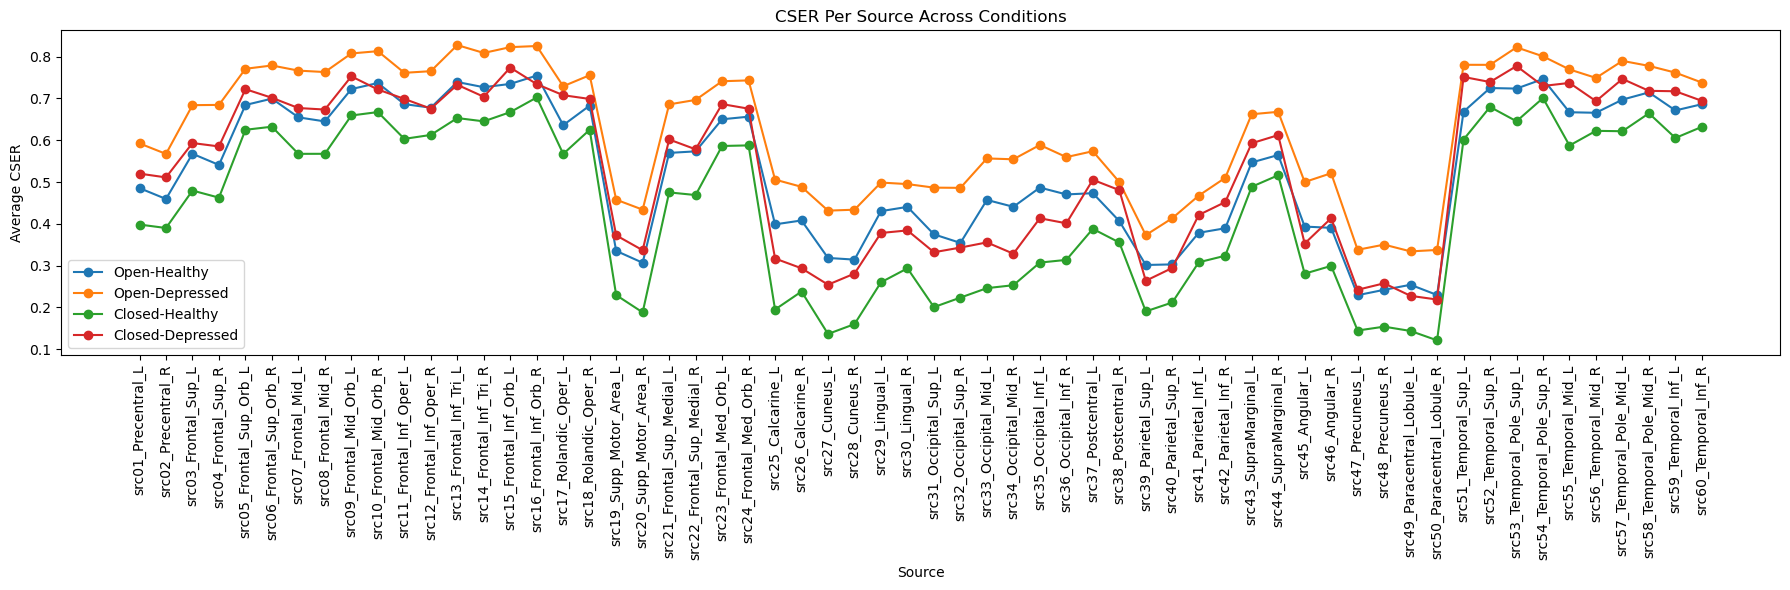

In [6]:
source_indices = np.arange(1, 61)

plt.figure(figsize=(18, 6))
for eyes in ['open', 'closed']:
    for depressed in df['depressed'].unique():
        mask = (df['eyes'] == eyes) & (df['depressed'] == depressed) & (df['band'] == 'broadband')
        avg = df.loc[mask, 'CSER'].groupby(df['area']).mean().reindex([f'src{i+1:02d}_{source_names[i]}' for i in range(60)])
        plt.plot(source_indices, avg, marker='o', label=f'{eyes.capitalize()}-{'Depressed' if depressed else 'Healthy'}')

plt.xticks(source_indices, [f'src{idx+1:02d}_{source_names[idx]}' for idx in range(60)], rotation=90)
plt.xlabel('Source')
plt.ylabel('Average CSER')
plt.title('CSER Per Source Across Conditions')
plt.legend()
plt.tight_layout()
plt.show()

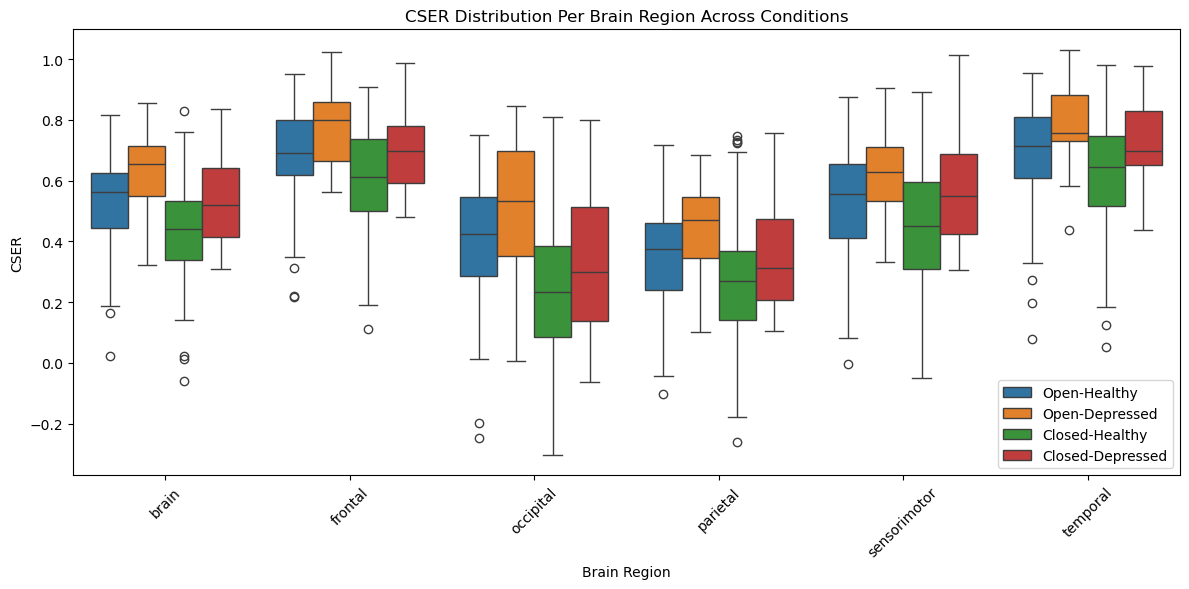

In [7]:
# Plotting CSER distribution across brain regions
mask = (df['band'] == 'broadband') & (~df['area'].str.startswith('src'))
df_regions = df.loc[mask, ['area', 'CSER', 'eyes', 'depressed']].copy()
df_regions['eyes'] = df_regions['eyes'].str.capitalize()
df_regions['depressed'] = df_regions['depressed'].apply(lambda x: 'Depressed' if x==1 else 'Healthy')
df_regions['condition'] = df_regions['eyes'] + '-' + df_regions['depressed']

df_regions['condition'] = pd.Categorical(df_regions['condition'], 
                                        categories=['Open-Healthy', 'Open-Depressed', 'Closed-Healthy', 'Closed-Depressed'],
                                        ordered=True)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_regions, x='area', y='CSER', hue='condition')

plt.xlabel('Brain Region')
plt.ylabel('CSER')
plt.title('CSER Distribution Per Brain Region Across Conditions')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

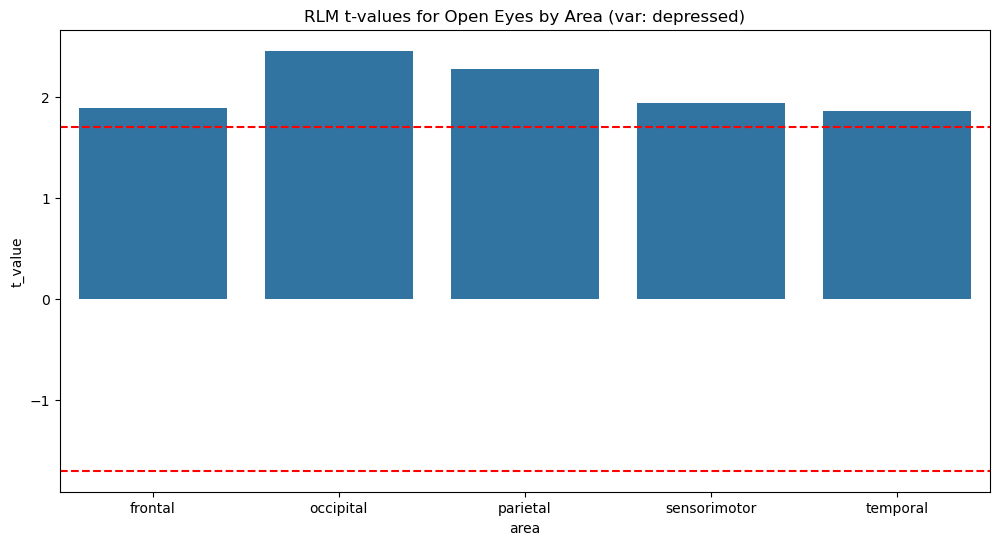

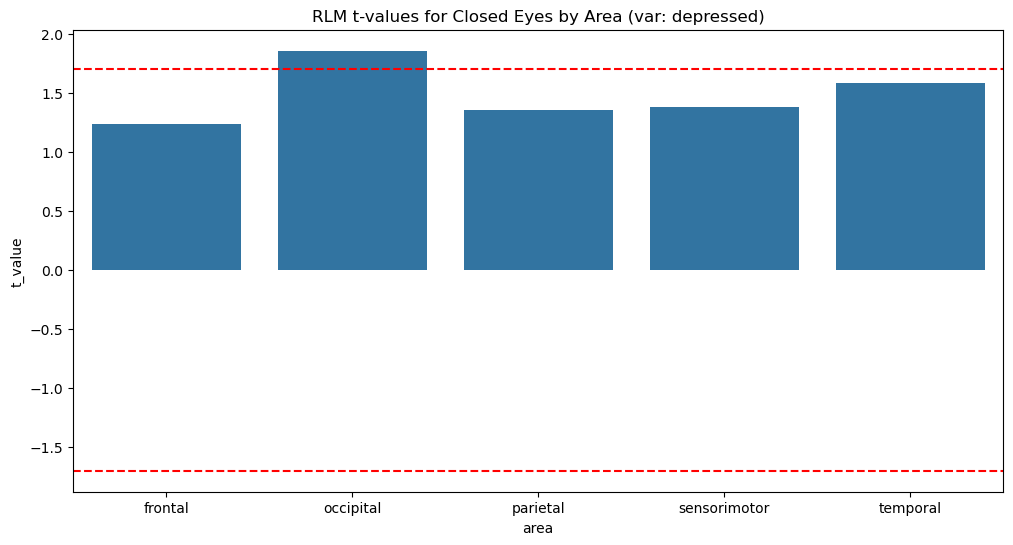

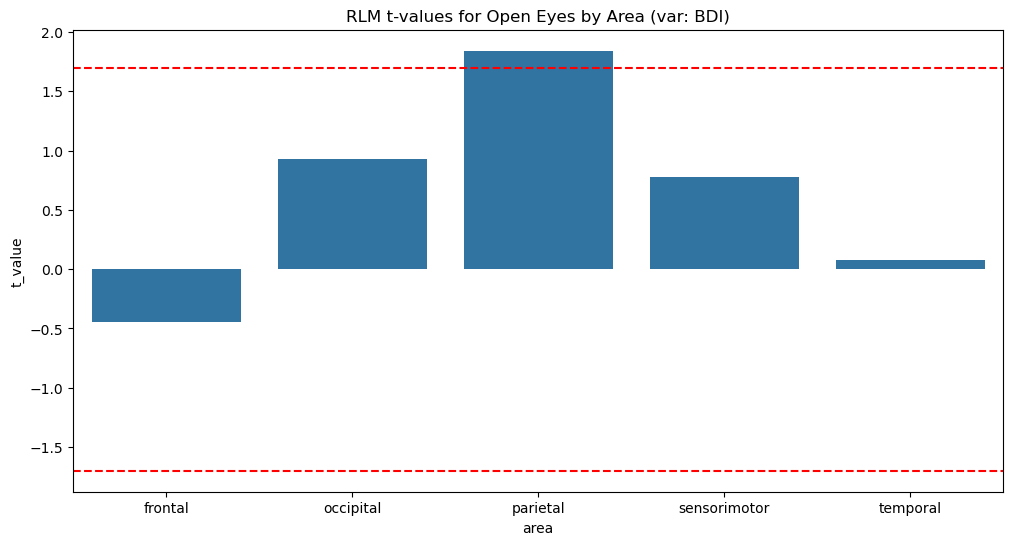

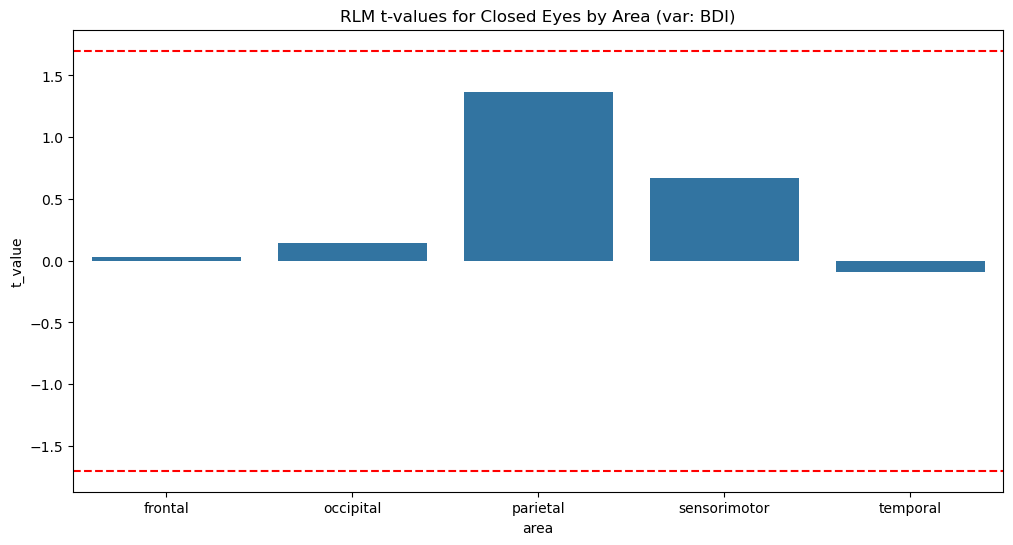

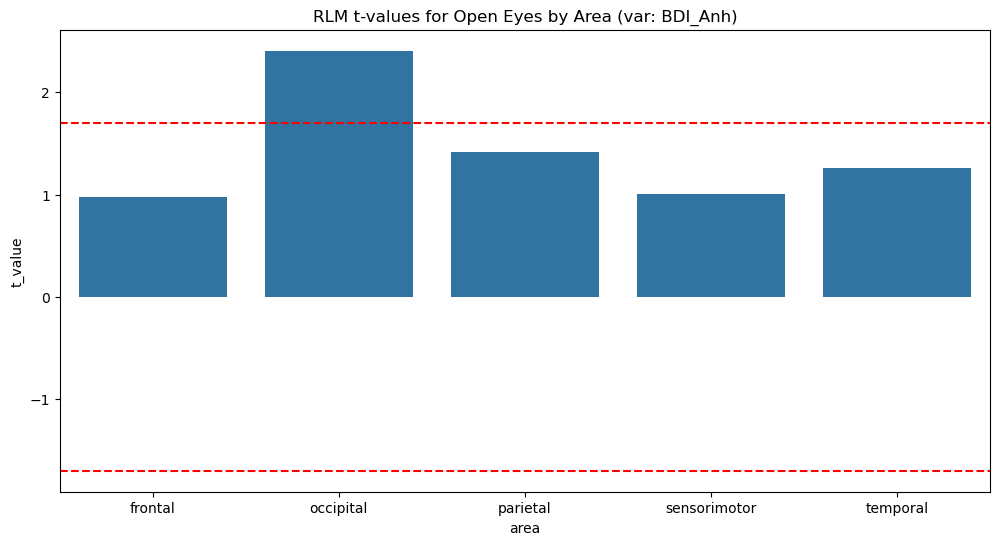

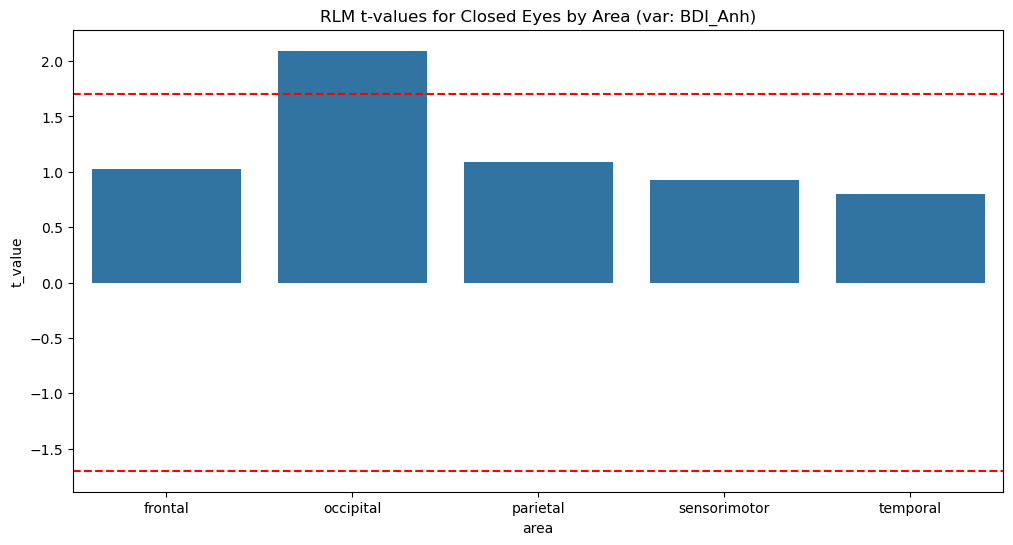

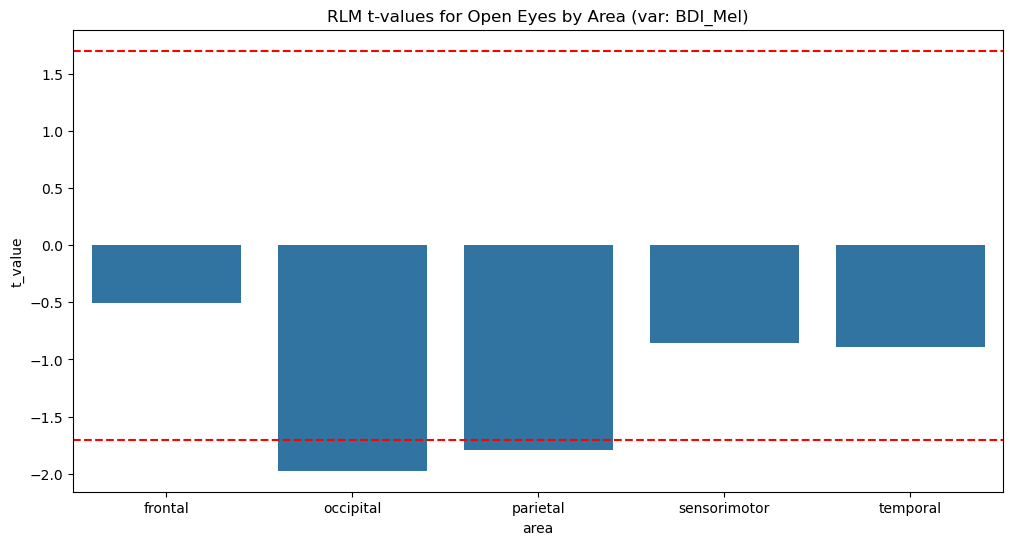

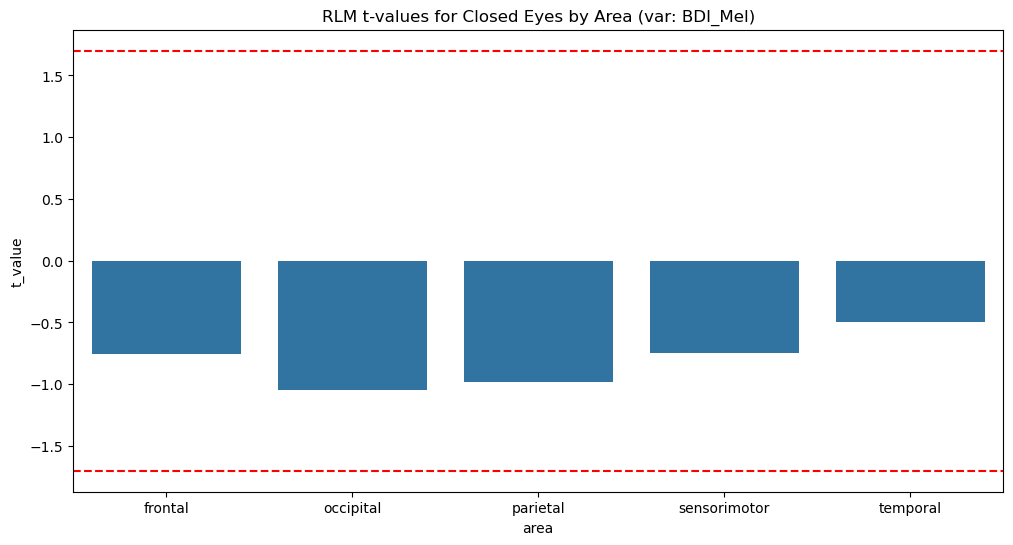

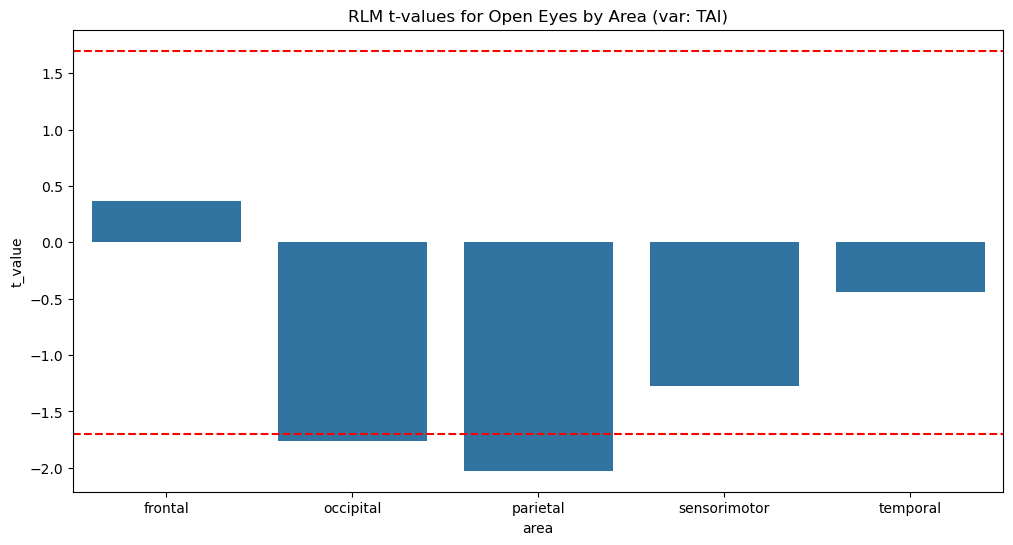

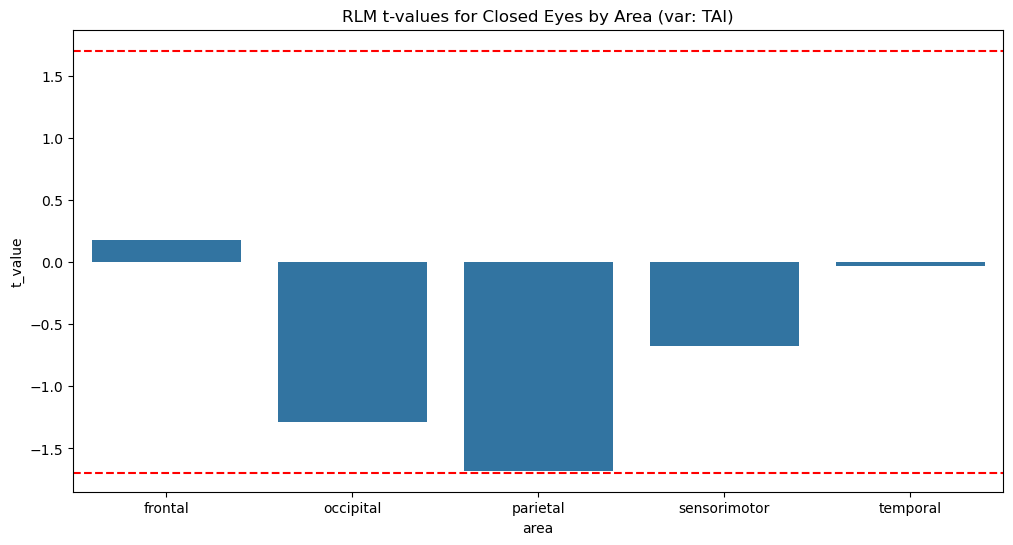

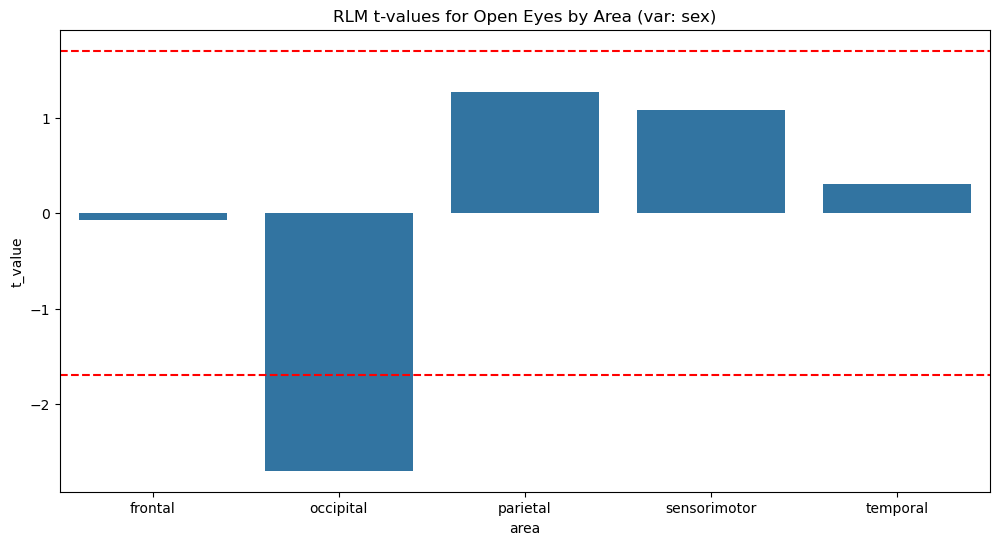

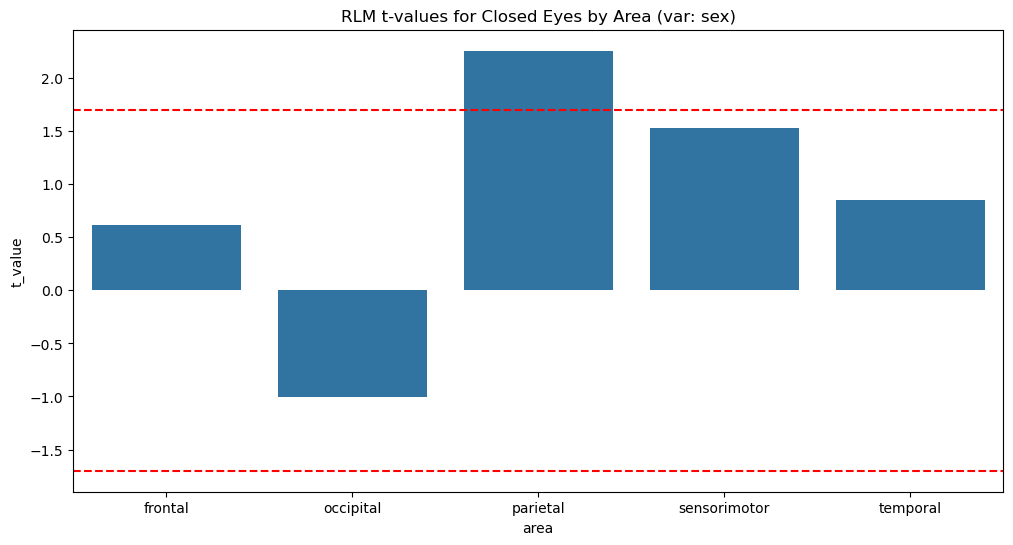

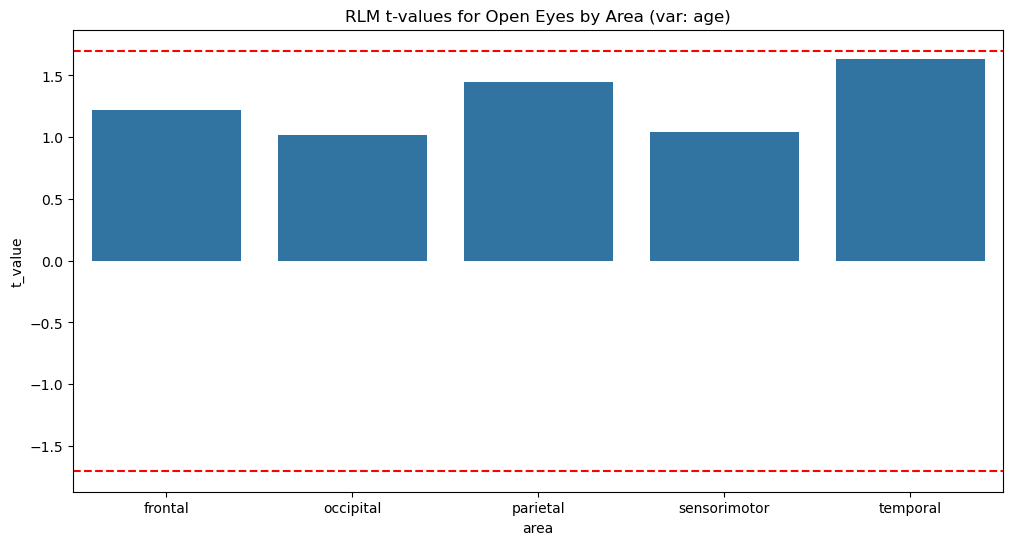

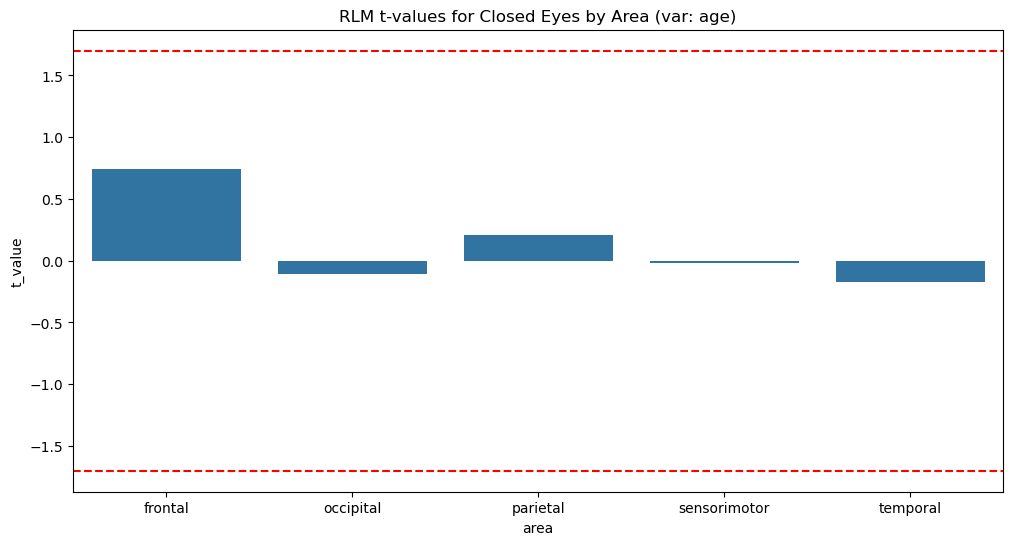

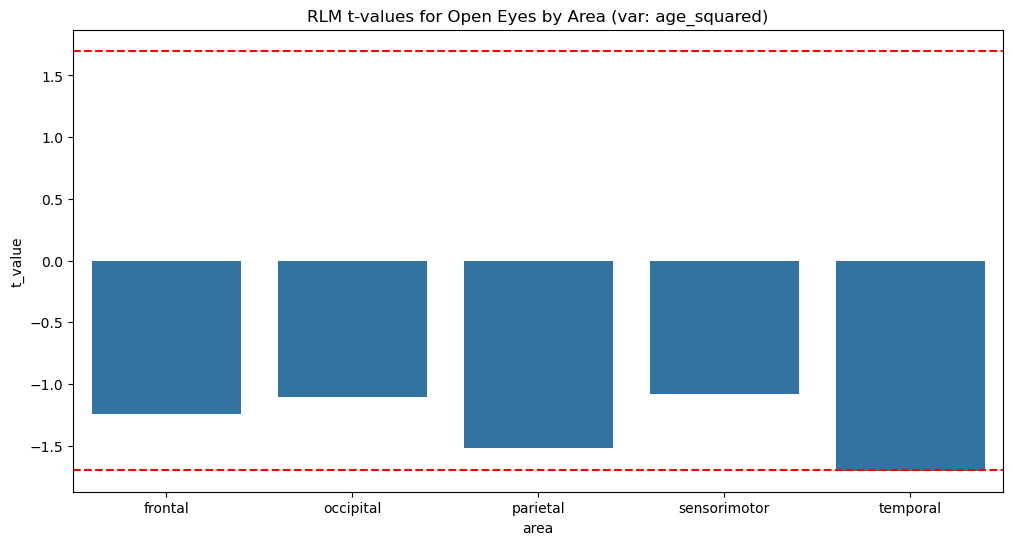

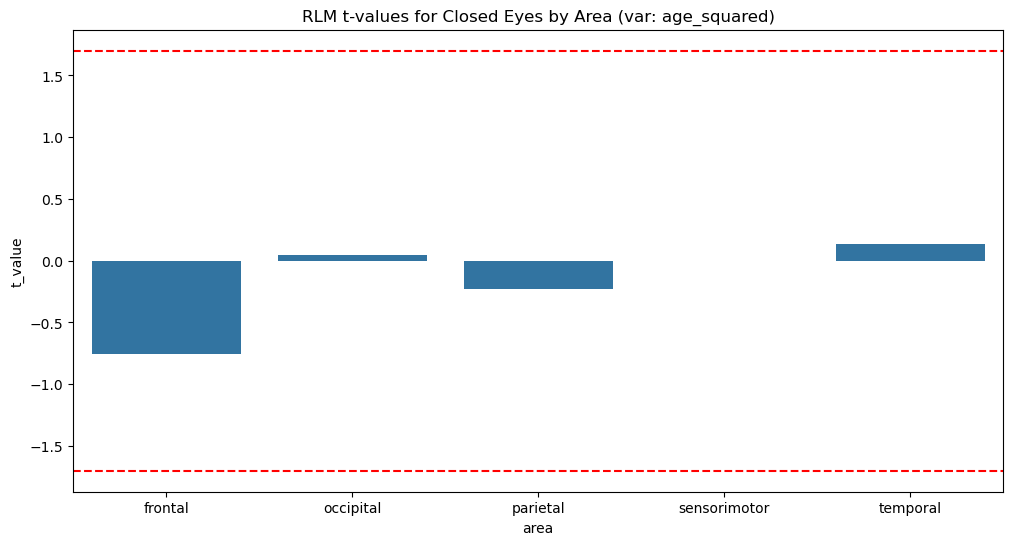

In [132]:
def barplot_significance(eyes, var):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=rlm_results[(rlm_results['eyes'] == eyes) & (rlm_results['band'] == 'broadband') & (rlm_results['variable'] == var) & (rlm_results['area'].isin(region_map.keys()))],
                x='area', y='t_value', errorbar=None)
    plt.title(f'RLM t-values for {str.capitalize(eyes)} Eyes by Area (var: {var})')
    plt.axhline(y=1.7, color='r', linestyle='--')
    plt.axhline(y=-1.7, color='r', linestyle='--')
    plt.show()
    

for var in variables:
    if var in ['intercept']:
        continue
    barplot_significance('open', var)
    barplot_significance('closed', var)

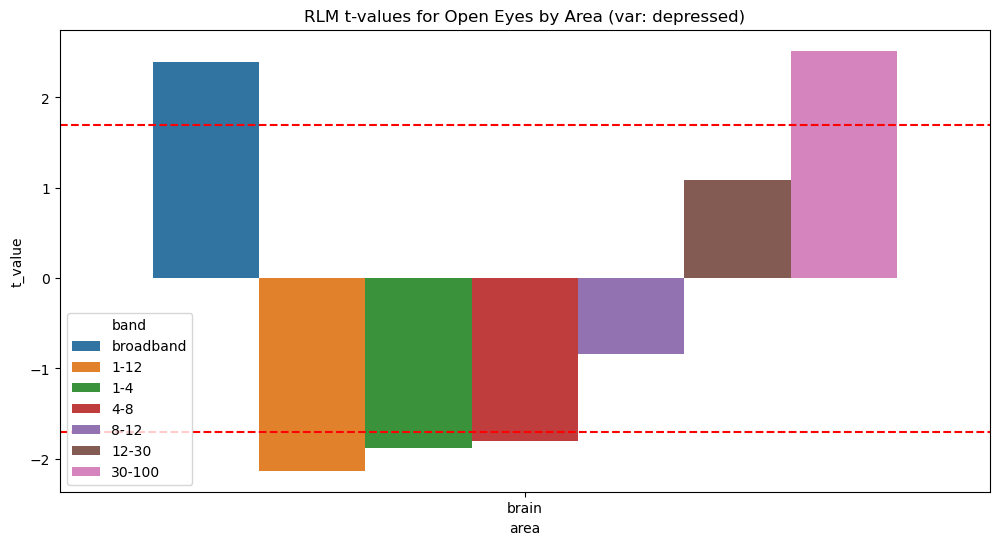

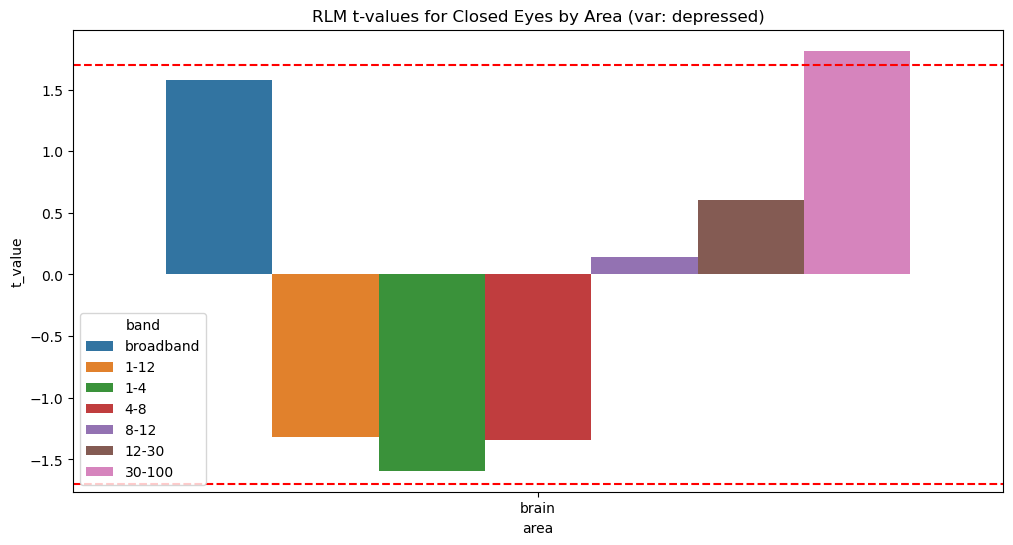

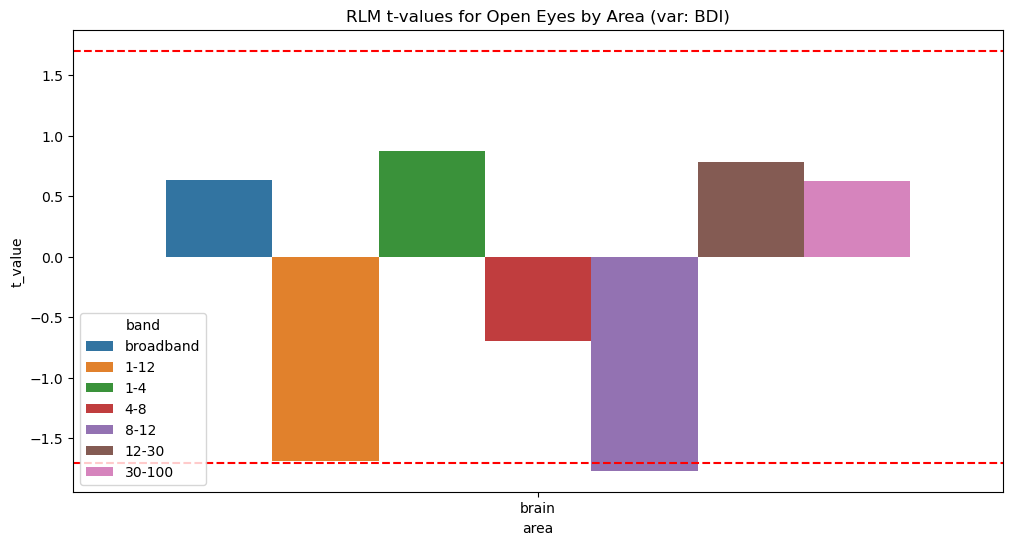

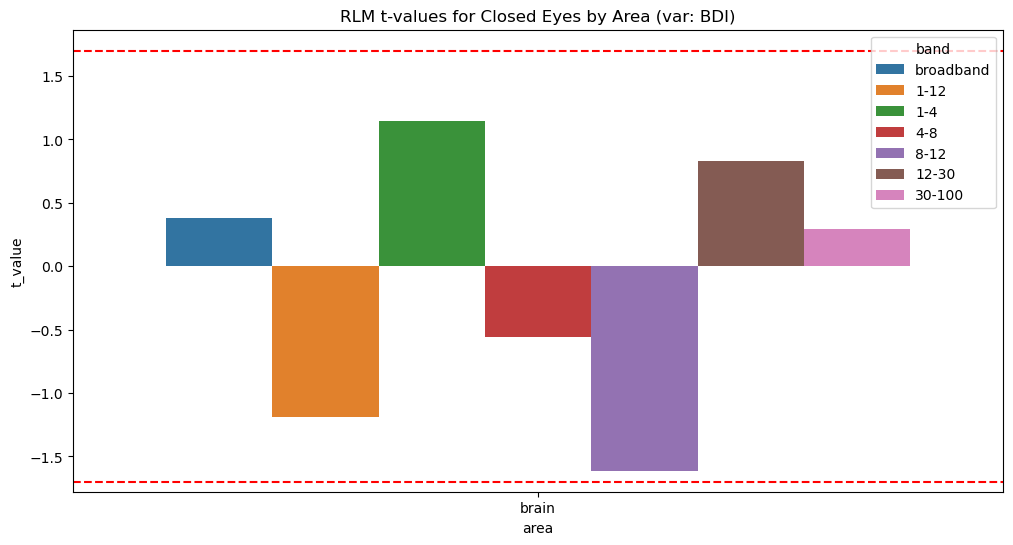

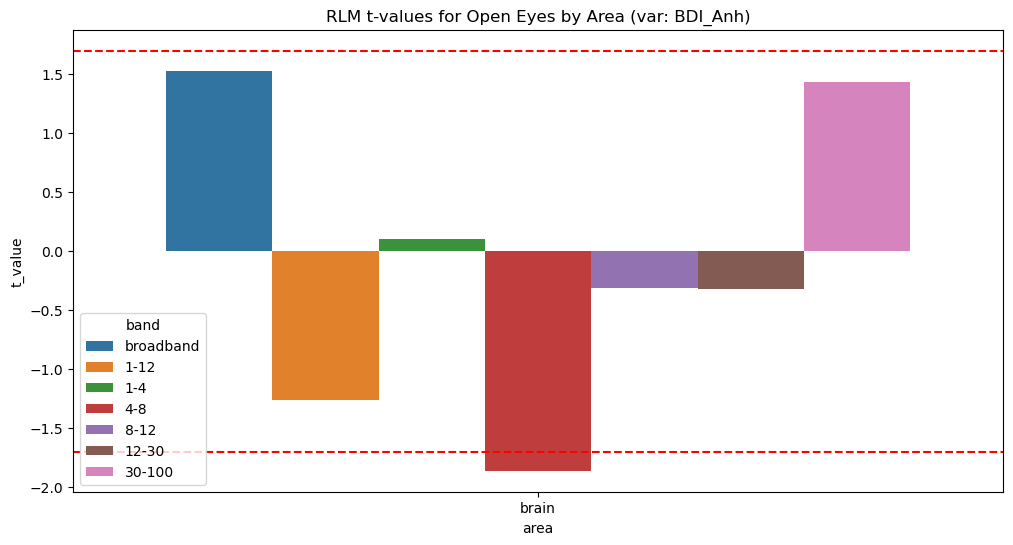

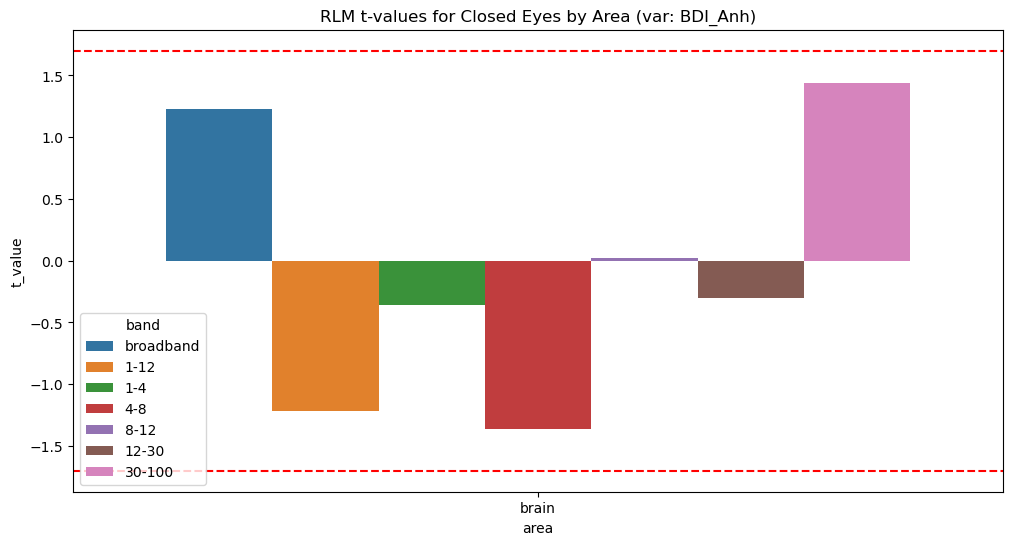

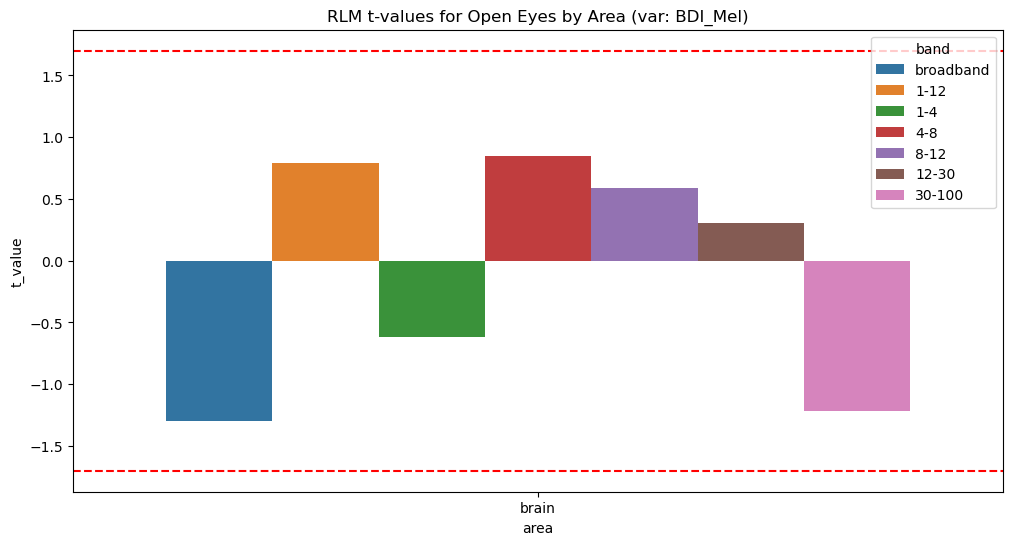

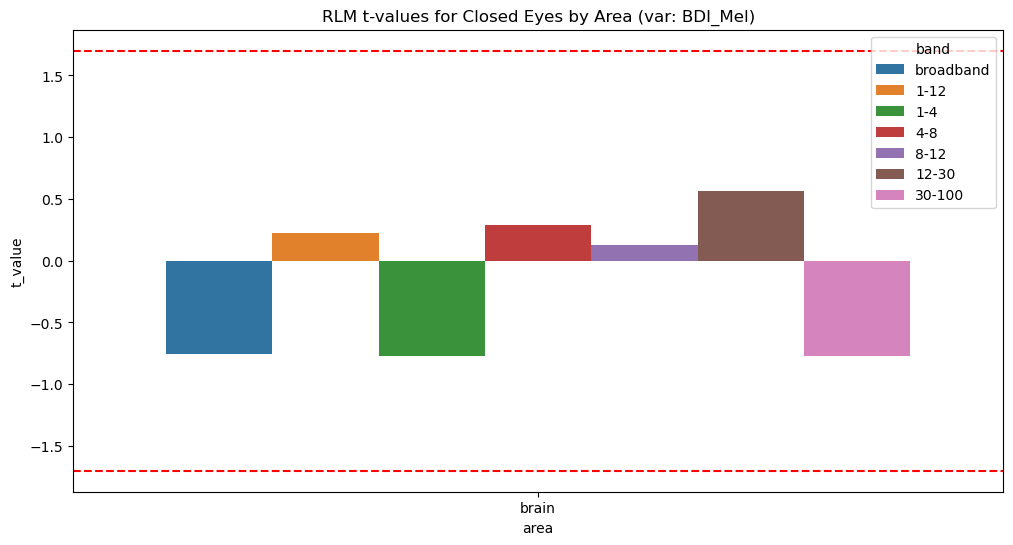

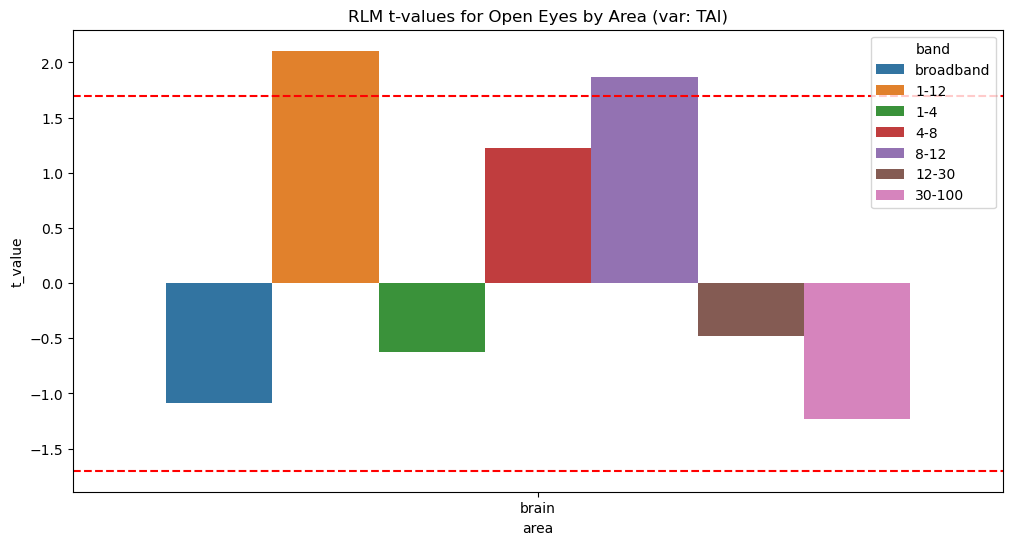

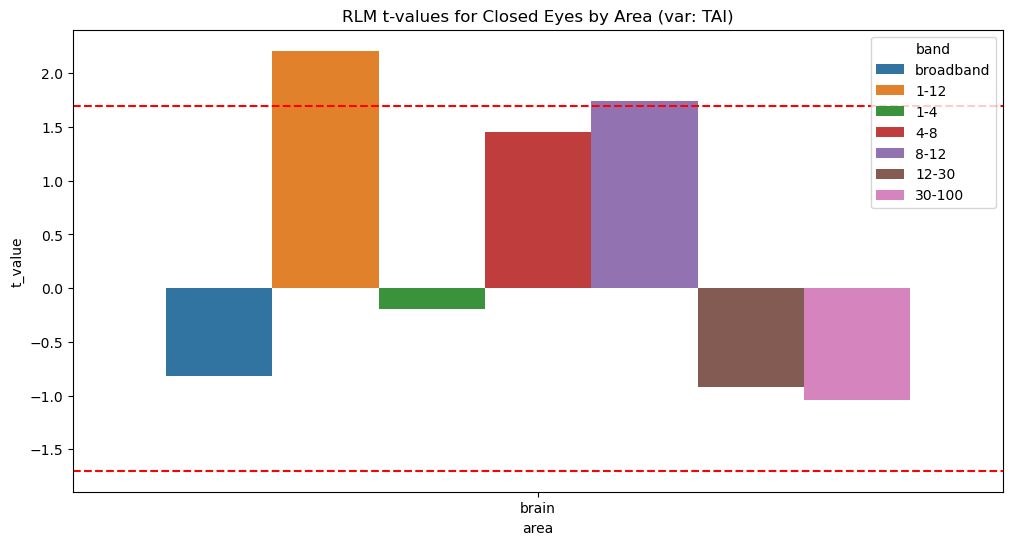

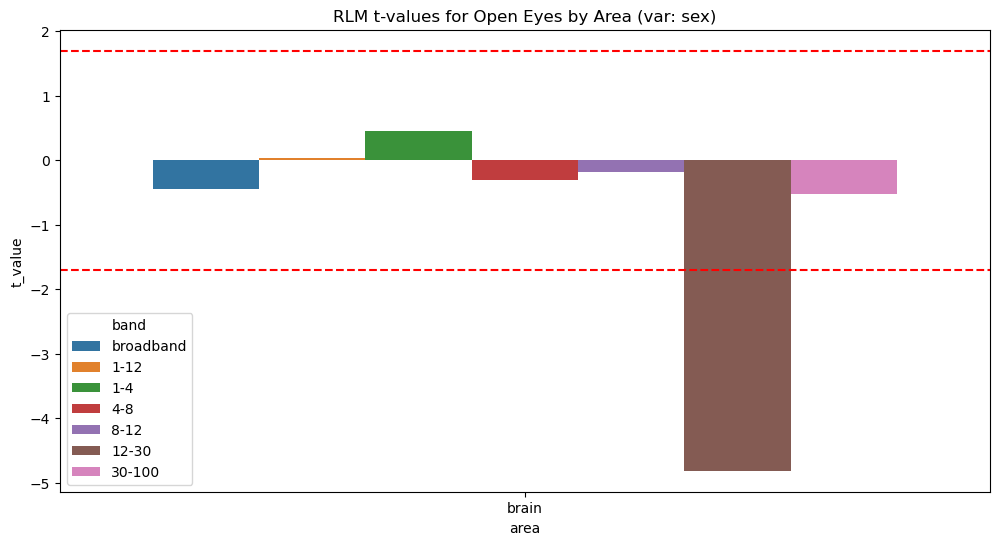

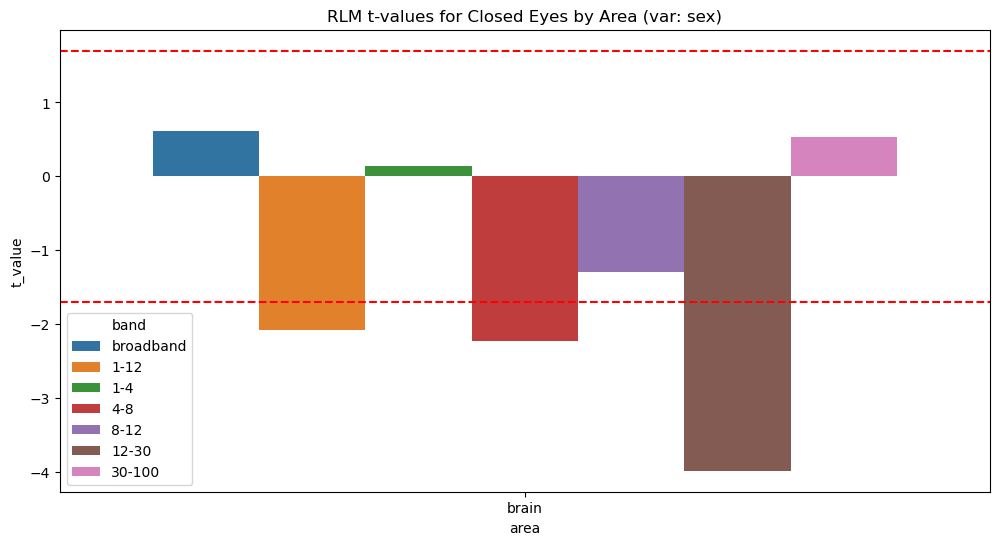

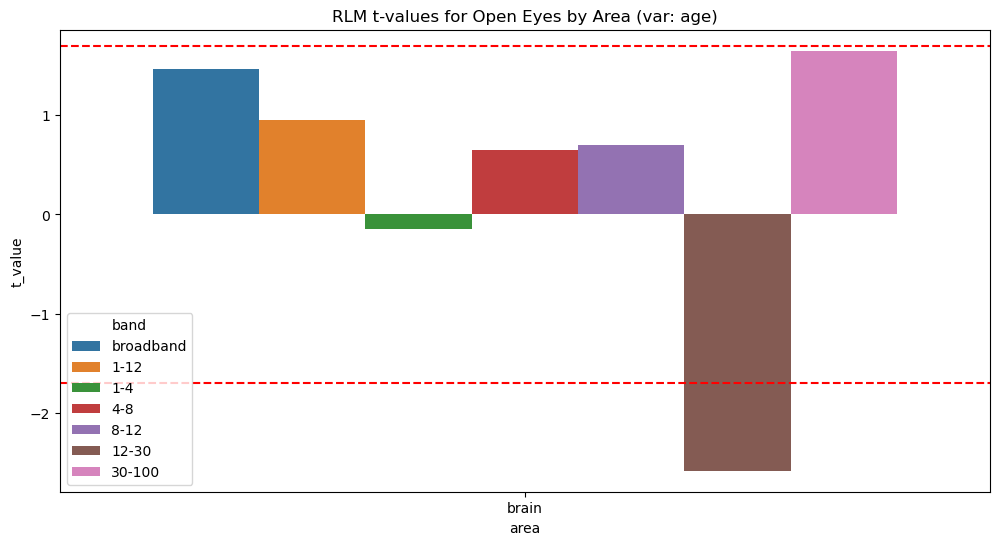

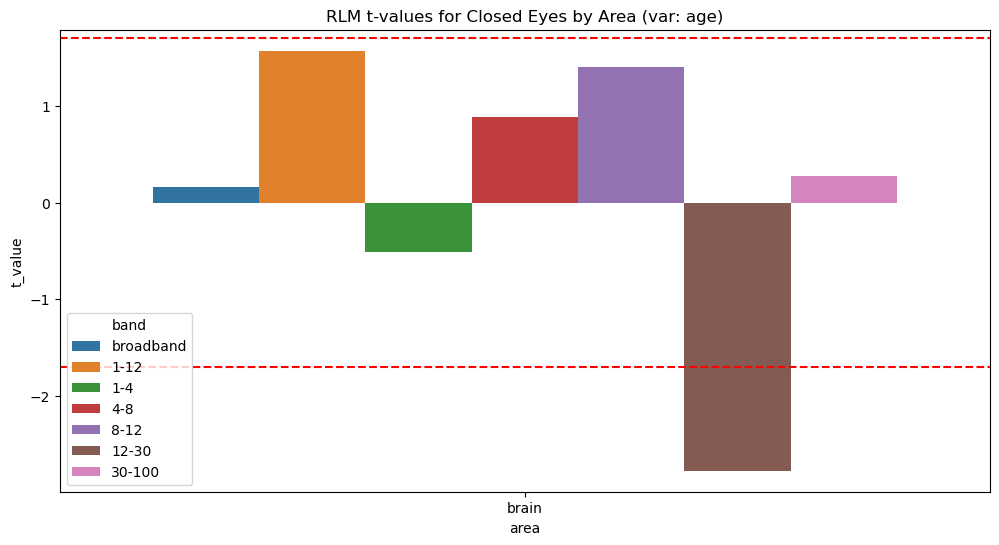

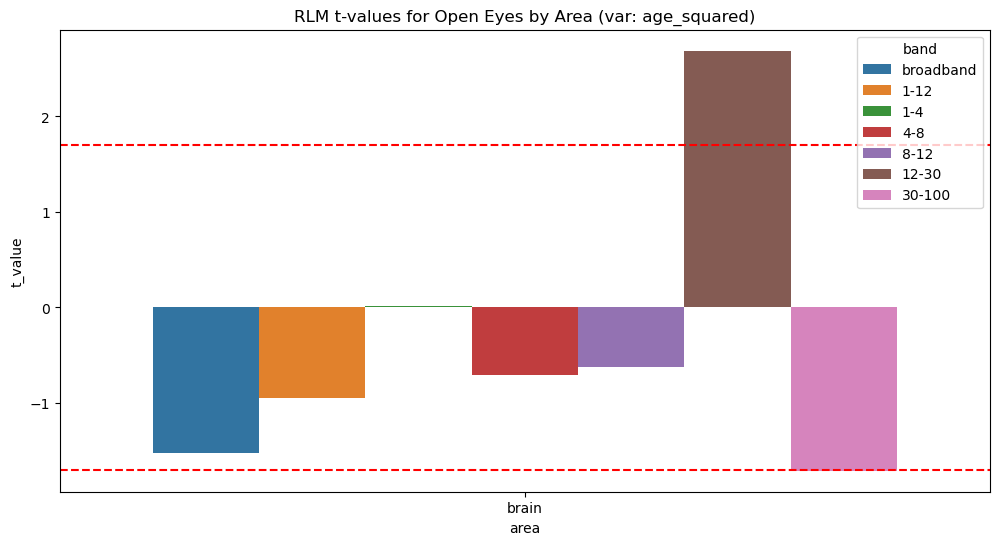

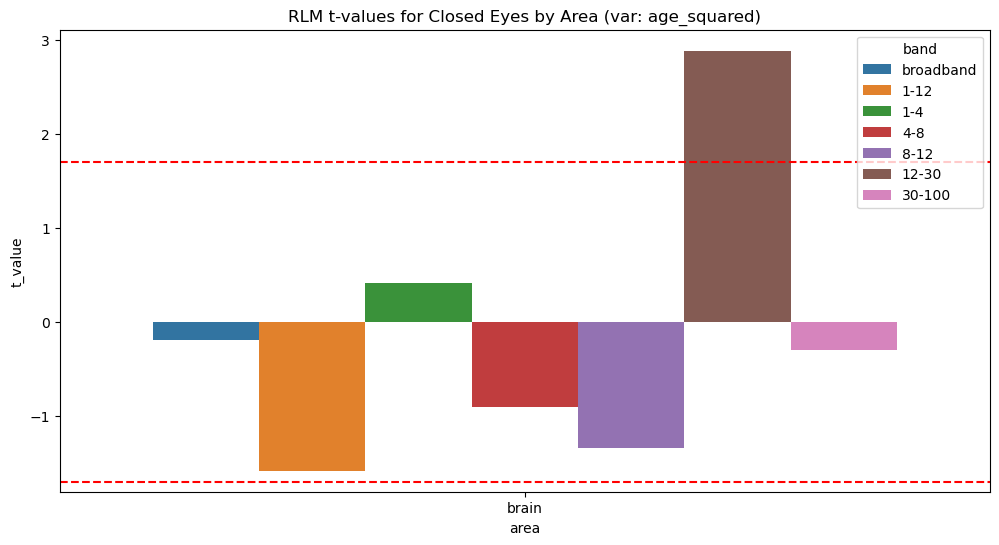

In [137]:
def barplot_significance(eyes, var):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=rlm_results[(rlm_results['eyes'] == eyes) & (rlm_results['variable'] == var) & (rlm_results['area'] == 'brain')],
                x='area', y='t_value', hue='band', errorbar=None)
    plt.title(f'RLM t-values for {str.capitalize(eyes)} Eyes by Area (var: {var})')
    plt.axhline(y=1.7, color='r', linestyle='--')
    plt.axhline(y=-1.7, color='r', linestyle='--')
    plt.show()
    

for var in variables:
    if var in ['intercept']:
        continue
    barplot_significance('open', var)
    barplot_significance('closed', var)

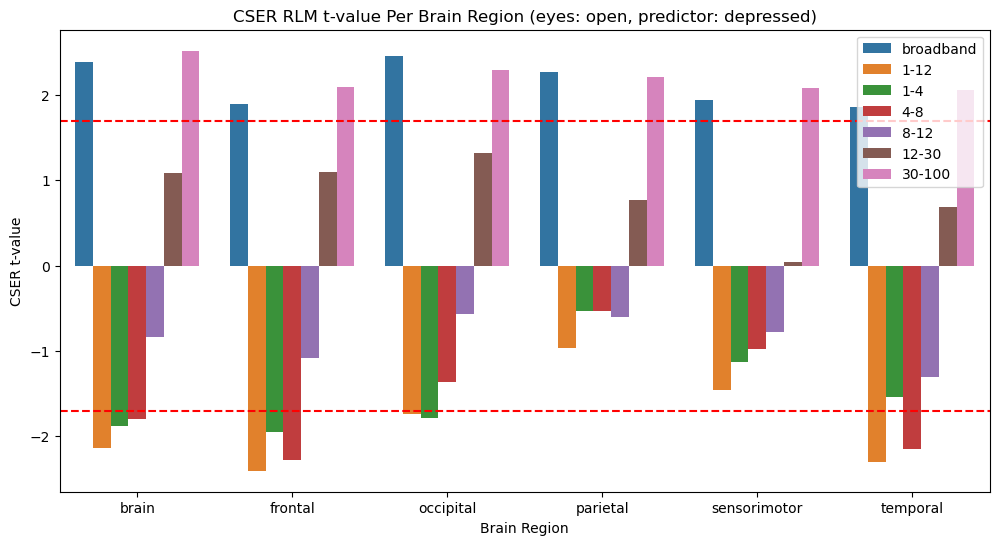

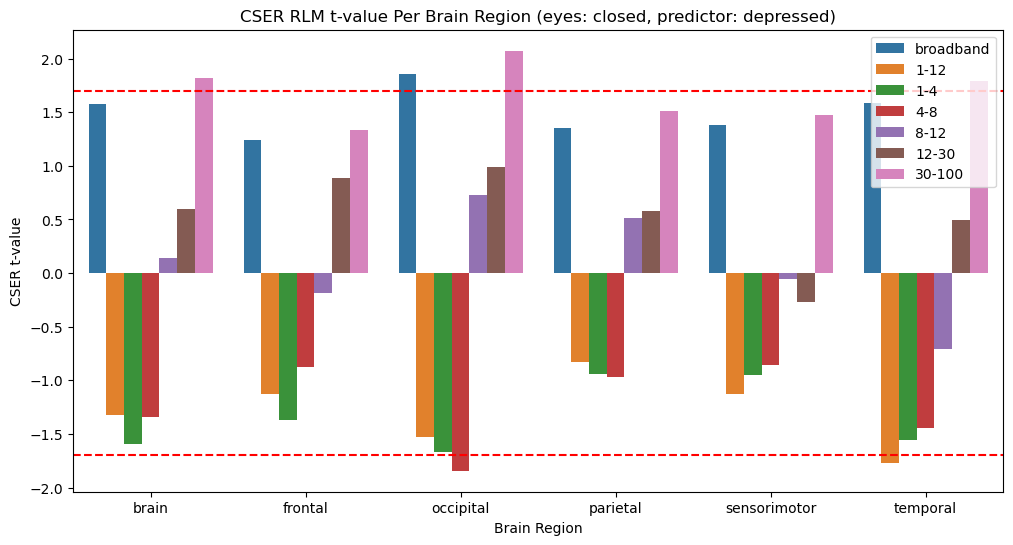

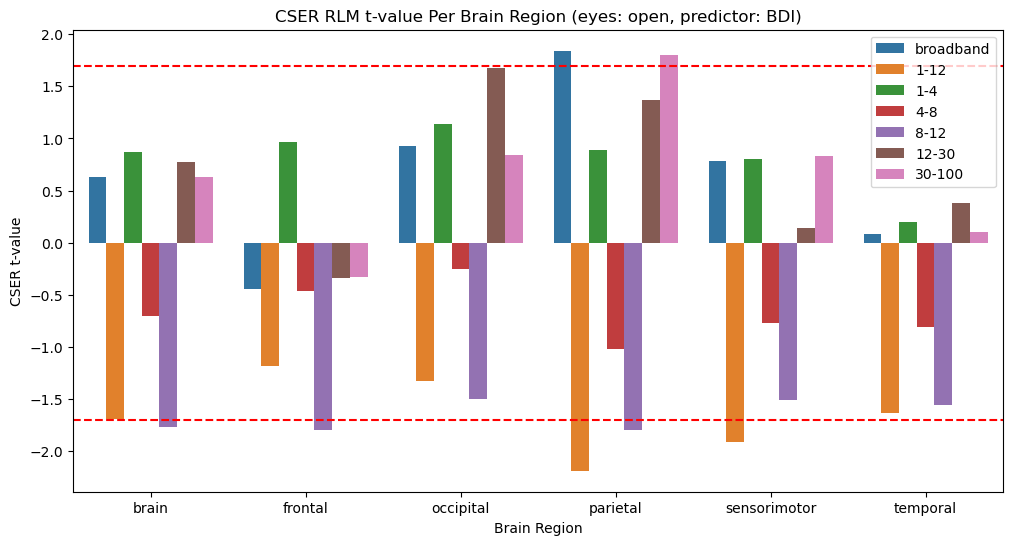

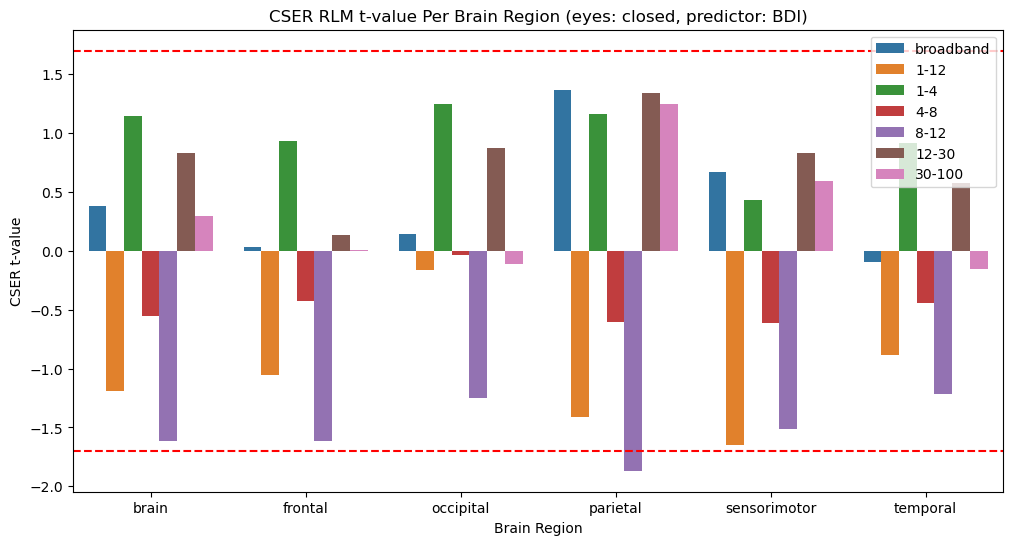

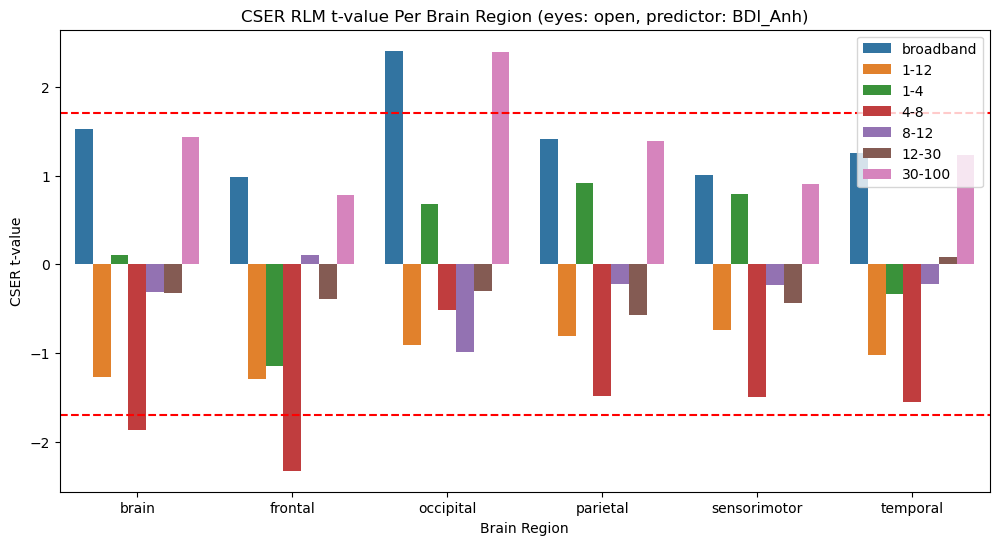

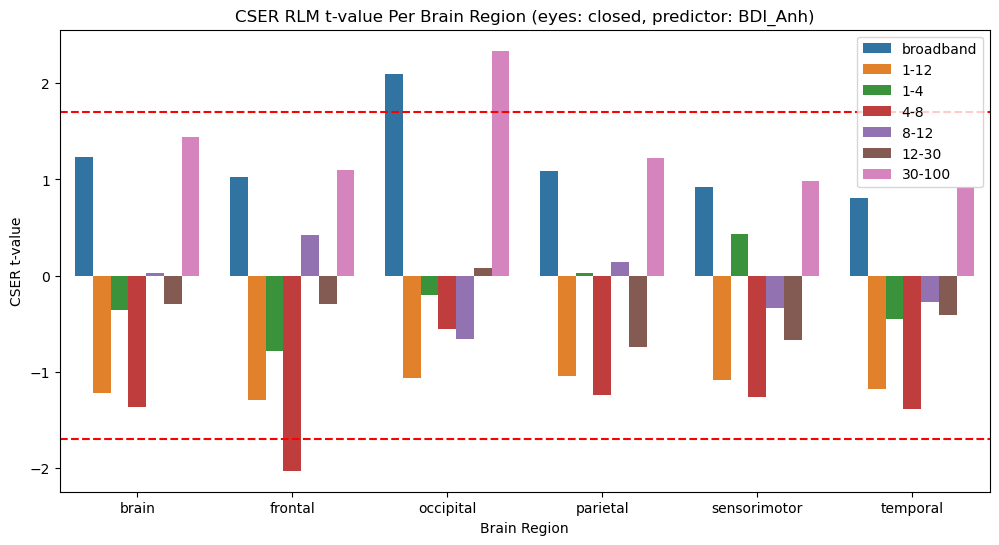

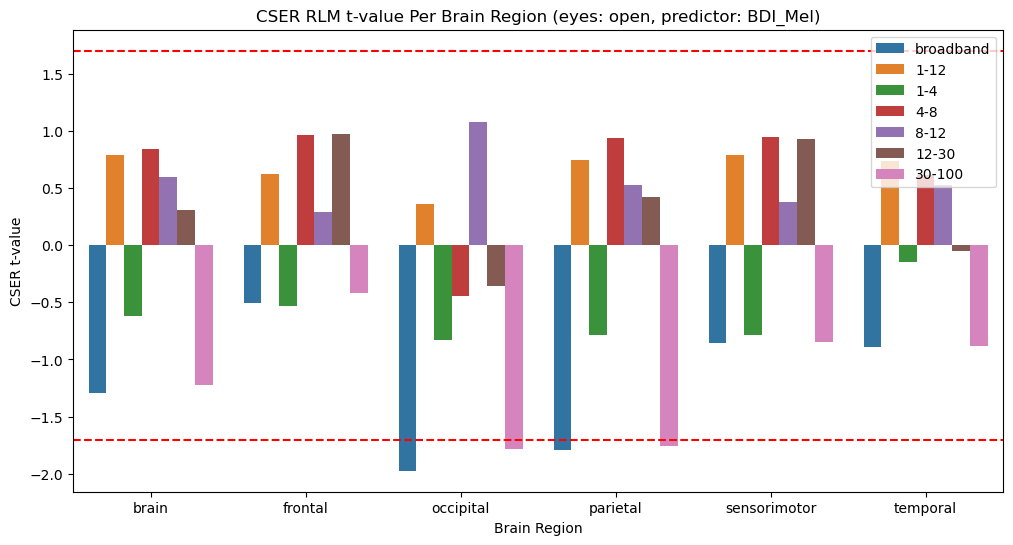

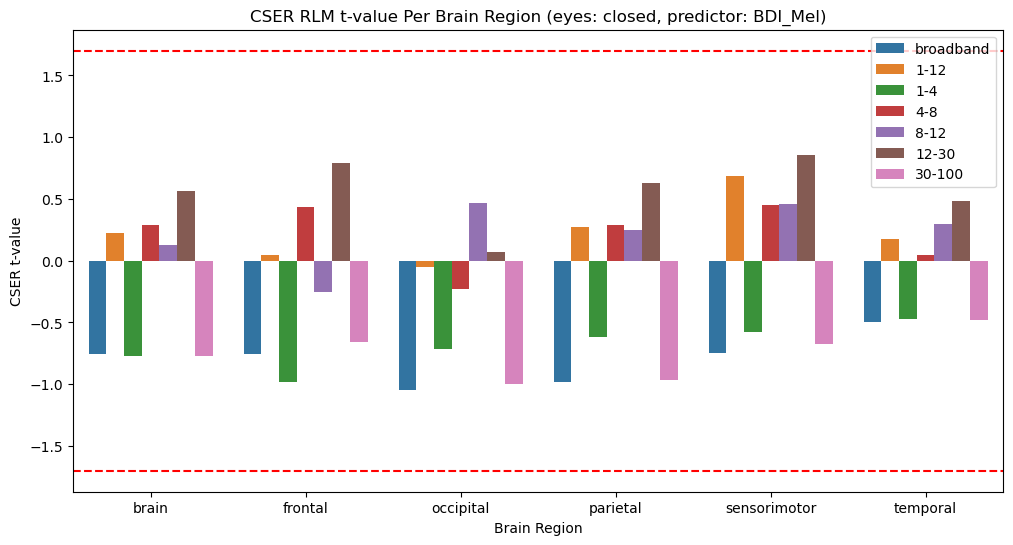

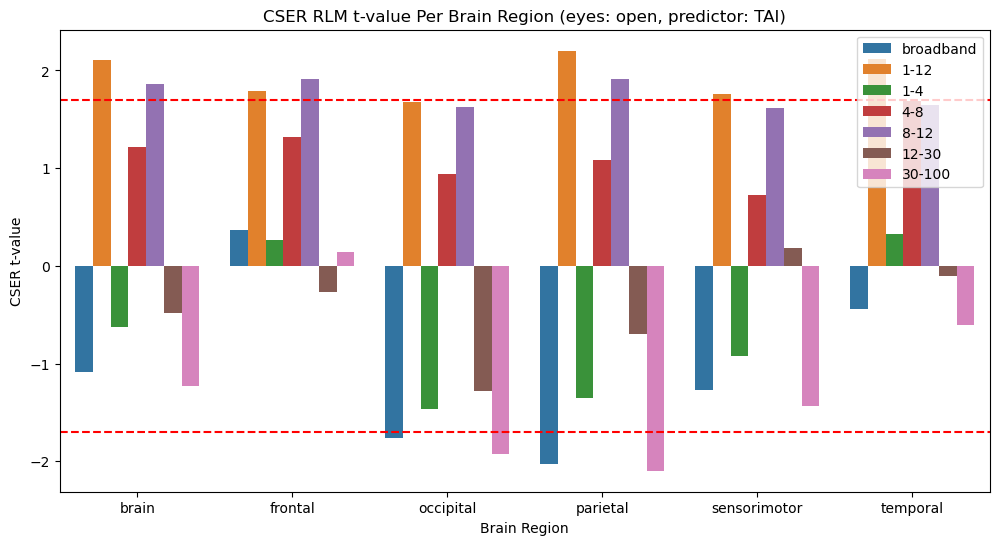

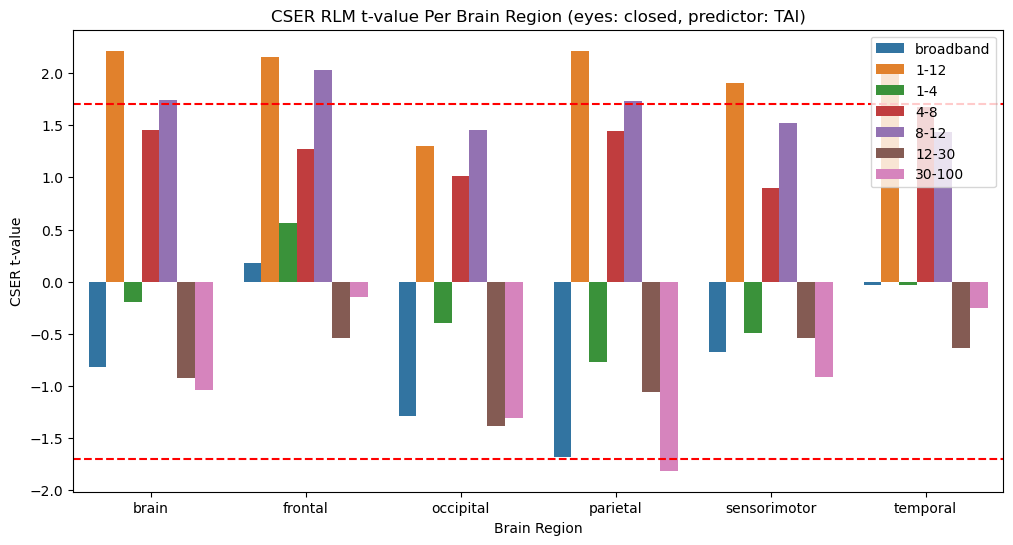

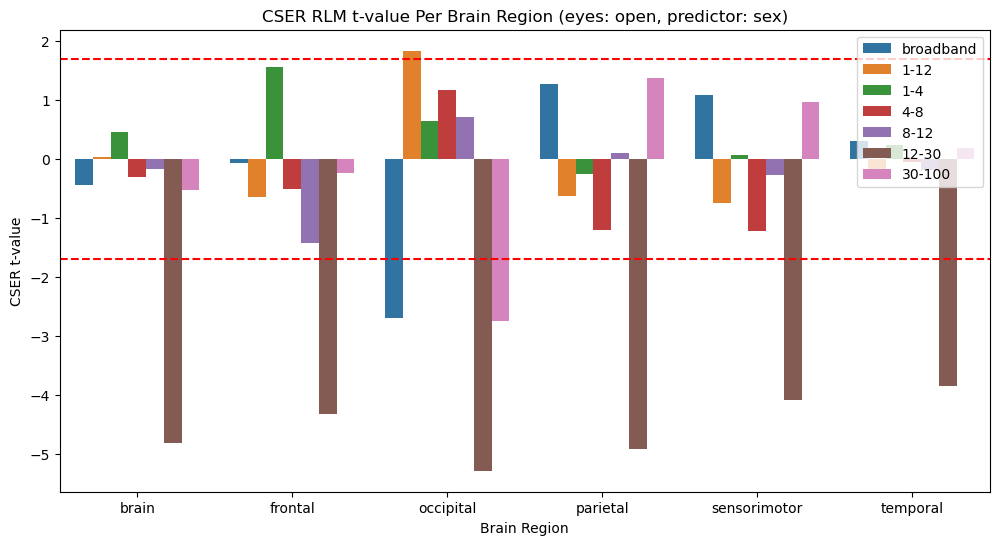

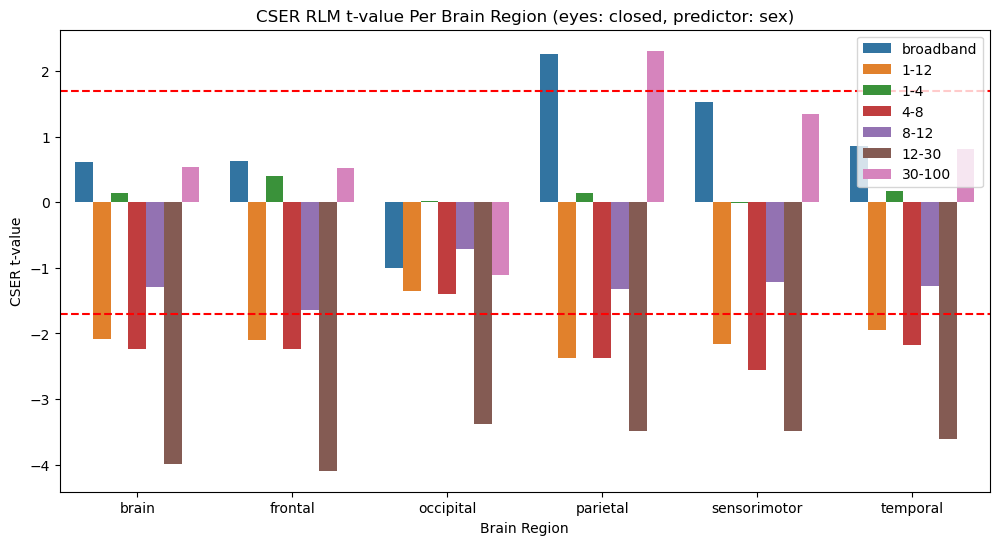

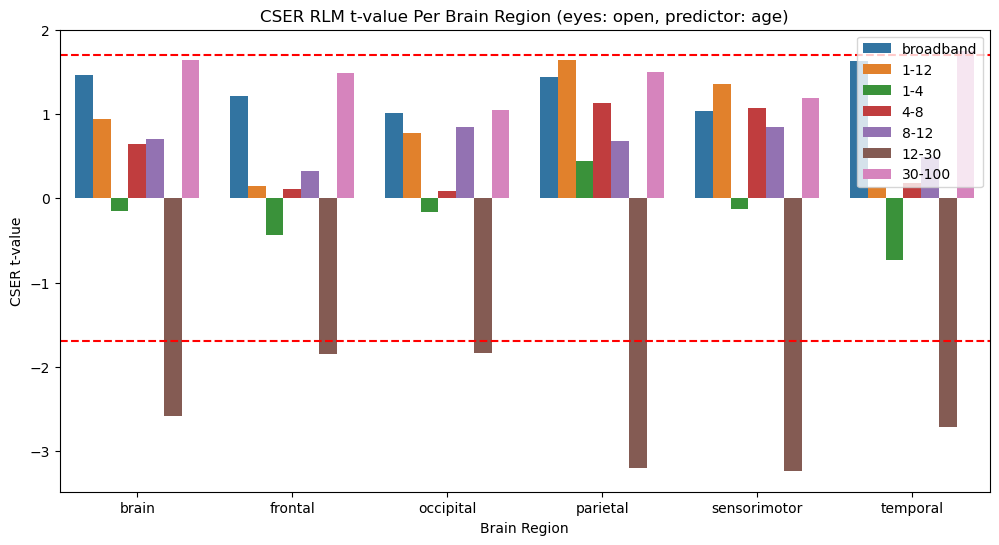

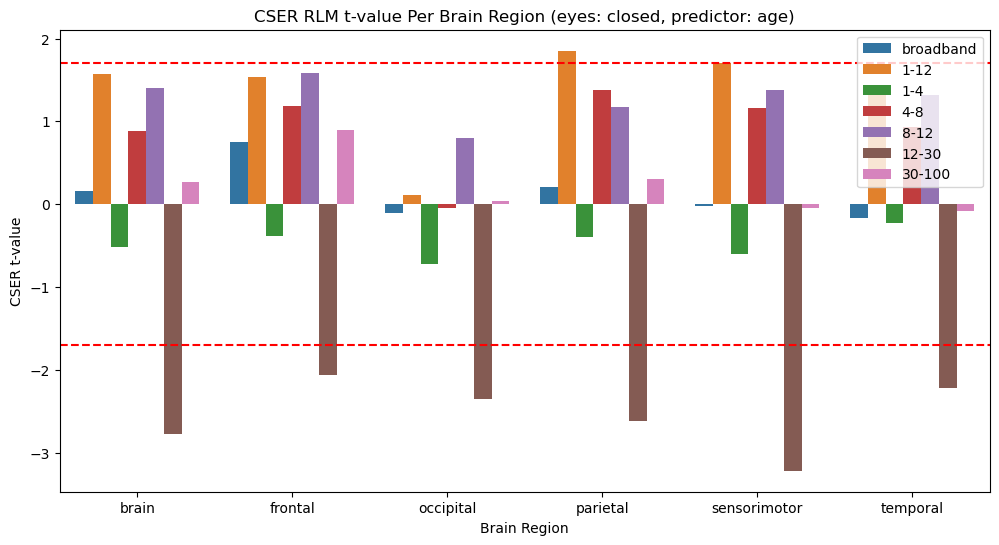

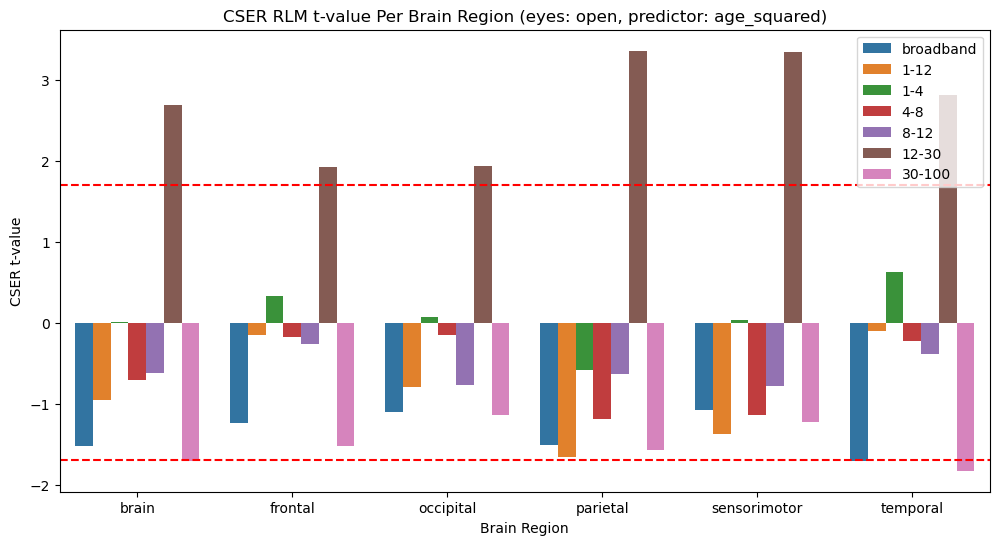

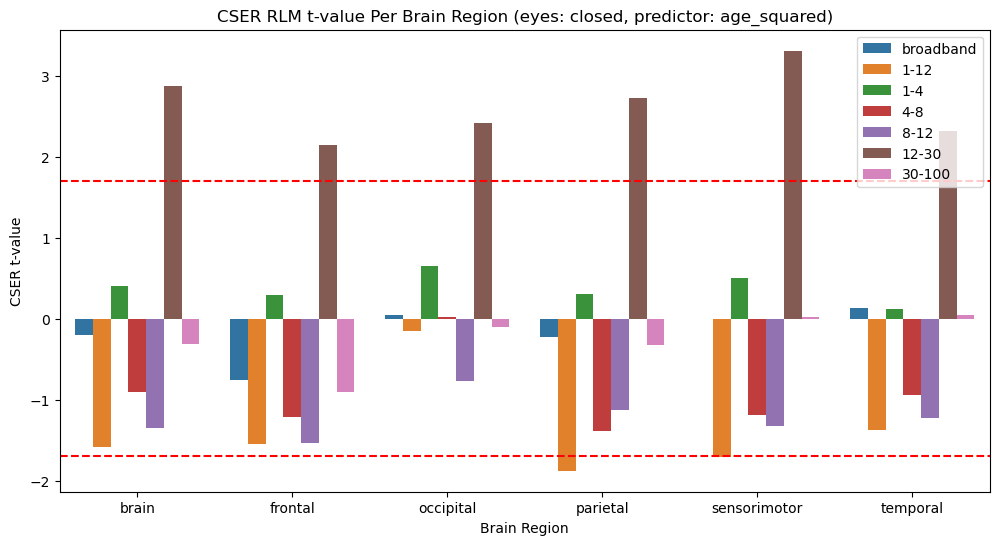

In [12]:
def barplot_significance(eyes, var):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=rlm_results[(rlm_results['eyes'] == eyes) & (rlm_results['variable'] == var) & (rlm_results['area'].isin(['brain'] + list(region_map.keys())))],
                x='area', y='t_value', hue='band', errorbar=None)
    plt.title(f'CSER RLM t-value Per Brain Region (eyes: {eyes}, predictor: {var})')
    plt.xlabel('Brain Region')
    plt.ylabel('CSER t-value')
    plt.axhline(y=1.7, color='r', linestyle='--')
    plt.axhline(y=-1.7, color='r', linestyle='--')
    plt.legend(loc='upper right')
    plt.show()
    

for var in variables:
    if var in ['intercept']:
        continue
    barplot_significance('open', var)
    barplot_significance('closed', var)

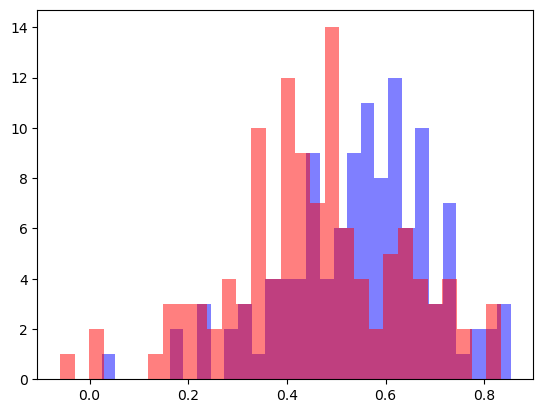

In [89]:
# Plot the distribution of CSER values with eyes set to 'open' and 'closed'
mask_open = (df['eyes'] == 'open') & (df['area'] == 'brain') & (df['band'] == 'broadband')
mask_closed = (df['eyes'] == 'closed') & (df['area'] == 'brain') & (df['band'] == 'broadband')

plt.hist(df[mask_open]['CSER'].dropna(), bins=30, alpha=0.5, color='blue', label='CSER Open');
plt.hist(df[mask_closed]['CSER'].dropna(), bins=30, alpha=0.5, color='red', label='CSER Closed');

## EXCEL & PICKLE EXPORT

In [135]:
date_str = datetime.now().strftime("%Y_%m_%d - %H_%M")

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_excel_path = os.path.join(output_dir, f"CSER - {date_str}.xlsx")

with pd.ExcelWriter(output_excel_path) as writer:
    cser_mean_band_area.to_excel(writer, sheet_name='CSER Band Area')
    cser_mean_band_area_pivot.to_excel(writer, sheet_name='CSER Band Area (Pivot)')
    
    cser_mean_band_pivot.to_excel(writer, sheet_name='CSER Band')
    cser_mean_area_pivot.to_excel(writer, sheet_name='CSER Area')

    rlm_results.to_excel(writer, sheet_name='RLM Results')
    significant_results.to_excel(writer, sheet_name='Significant Results')

In [ ]:
# date_str = datetime.now().strftime("%Y_%m_%d - %H_%M")

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_pickle_path = os.path.join(output_dir, f"CSER - {date_str}.pkl")

pickle_dict = {
    'cser_mean_band_area': cser_mean_band_area,
    'cser_mean_band_area_pivot': cser_mean_band_area_pivot,
    'cser_mean_band_pivot': cser_mean_band_pivot,
    'cser_mean_area_pivot': cser_mean_area_pivot,
    'rlm_results': rlm_results,
    'significant_results': significant_results
}

with open(output_pickle_path, 'wb') as f:
    pd.to_pickle(pickle_dict, f)